## Libraries

In [1]:
# data processing and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# system library
from pathlib import Path

# stats and maths
from  scipy.stats import skew, kurtosis, shapiro
from math import log
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import math

# Data transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# model selection
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor


import tensorflow as tf


## Load Data
### Energy Demand

In [2]:
def load_df(p, fName):
    test = pd.read_csv(p / fName, 
                   index_col= 1,
                   parse_dates=True,
                   infer_datetime_format=True,
                   names=['STATE','DEMAND','PRICE','CAT'],
                   skiprows=1)
    
    return test

In [3]:
demand = pd.DataFrame(columns=['STATE','DEMAND','PRICE','CAT'])
states = ['NSW', 'VIC', 'QLD', 'SA', 'TAS']

for state in states:
    p = Path(state)
    # load data from 1999 to 2019
    for y in range(2013, 2020):
        year = str(y)
        for m in range(1,13):
            if(m/10 < 1):
                month = '0' + str(m)
            else:
                month = str(m)

            fName = year + '_' + month + '.csv'
            try:
                temp = load_df(p, fName)
                demand = demand.append(temp)
            except:
                print('Error, State: ' + state + 'Year: ' + year + 'Month: ' + month)

    # load 2020 data
    year = '2020'
    for m in range(1,10):
        if(m/10 < 1):
            month = '0' + str(m)
        else:
            month = str(m)

        fName = year + '_' + month + '.csv'
        try:
            temp = load_df(p, fName)
            demand = demand.append(temp)
        except:
            print('Error, State: ' + state + 'Year: ' + year + 'Month: ' + month)


In [4]:
print(demand.info())
demand.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 677520 entries, 2013-01-01 00:30:00 to 2020-09-24 00:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   STATE   677520 non-null  object 
 1   DEMAND  677520 non-null  float64
 2   PRICE   677520 non-null  float64
 3   CAT     677520 non-null  object 
dtypes: float64(2), object(2)
memory usage: 25.8+ MB
None


STATE   DEMAND  PRICE    CAT
2013-01-01 00:30:00  NSW1  7166.97  46.61  TRADE
2013-01-01 01:00:00  NSW1  6928.11  46.32  TRADE
2013-01-01 01:30:00  NSW1  6541.21  44.76  TRADE
2013-01-01 02:00:00  NSW1  6253.60  42.86  TRADE
2013-01-01 02:30:00  NSW1  6003.44  42.86  TRADE

In [5]:
# Subset
demand_14_20 = demand['2014':'2020']

In [6]:
# missing values
demand_14_20.isna().sum()

STATE     0
DEMAND    0
PRICE     0
CAT       0
dtype: int64

In [7]:
demand_14_20['STATE'].unique()

array(['NSW1', 'VIC1', 'QLD1', 'SA1', 'TAS1'], dtype=object)

In [8]:
demand_14_20['STATE'].replace(to_replace={'NSW1':'NSW',
                                          'VIC1':'VIC',
                                          'QLD1':'QLD',
                                          'SA1':'SA',
                                          'TAS1':'TAS'},
                             inplace = True)
demand_14_20['STATE'].unique()

/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


array(['NSW', 'VIC', 'QLD', 'SA', 'TAS'], dtype=object)

In [9]:
demand_14_20.shape

(589925, 4)

### Weather

In [10]:
def load_weather(fName):
    # read csv
    data = pd.read_csv(Path('WeatherData') / fName)
    
    # make datetime index
    data.index = pd.to_datetime(data.iloc[:,2:5])
    
    # extract useful columns
    data = data.iloc[:,2:6]
    
    return data

In [11]:
# load weather data
minTemp = load_weather('min_temp_melbourne.csv')
maxTemp = load_weather('max_temp_melbourne.csv')
rain = load_weather('rainfall_melbourne.csv')
sun = load_weather('sun_exposure_melbourne.csv')

In [12]:
# concatenate weather data
weather = pd.concat([minTemp, 
                  maxTemp['Maximum temperature (Degree C)'],
                      rain['Rainfall amount (millimetres)'],
                  sun['Daily global solar exposure (MJ/m*m)']], axis=1)
weather.head()
#weather_17_19 = weather['2017':'2019']
weather_14_20 = weather['2014':'2020-09-29']
weather_14_20.head()

Year  Month  Day  Minimum temperature (Degree C)  \
2014-01-01  2014.0    1.0  1.0                            15.5   
2014-01-02  2014.0    1.0  2.0                            15.0   
2014-01-03  2014.0    1.0  3.0                            13.3   
2014-01-04  2014.0    1.0  4.0                            13.4   
2014-01-05  2014.0    1.0  5.0                            10.3   

            Maximum temperature (Degree C)  Rainfall amount (millimetres)  \
2014-01-01                            26.5                            0.0   
2014-01-02                            21.8                            5.2   
2014-01-03                            21.6                            0.0   
2014-01-04                            20.8                            0.0   
2014-01-05                            26.2                            0.2   

            Daily global solar exposure (MJ/m*m)  
2014-01-01                                   2.7  
2014-01-02                                  25.8  
2014-01-03                                  28.8  
2014-01-04                                  13.4  
2014-01-05                                  25.6

In [13]:
weather_14_20.tail()

Year  Month   Day  Minimum temperature (Degree C)  \
2020-09-25  2020.0    9.0  25.0                             7.2   
2020-09-26  2020.0    9.0  26.0                             6.2   
2020-09-27  2020.0    9.0  27.0                             8.8   
2020-09-28  2020.0    9.0  28.0                             6.5   
2020-09-29  2020.0    9.0  29.0                             4.3   

            Maximum temperature (Degree C)  Rainfall amount (millimetres)  \
2020-09-25                            11.9                            3.2   
2020-09-26                            13.4                            9.4   
2020-09-27                            13.4                            3.0   
2020-09-28                            13.6                            0.0   
2020-09-29                            21.0                            0.0   

            Daily global solar exposure (MJ/m*m)  
2020-09-25                                   7.2  
2020-09-26                                  15.0  
2020-09-27                                  20.9  
2020-09-28                                  18.3  
2020-09-29                                  18.4

In [14]:
# missing values
weather_14_20.isna().sum()

Year                                    0
Month                                   0
Day                                     0
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Rainfall amount (millimetres)           3
Daily global solar exposure (MJ/m*m)    1
dtype: int64

In [15]:
# function to fill with mean from prev and next
def fillWithMean(srs):
    for i in range(0,srs.shape[0]):
        if math.isnan(srs[i]):
            x = 0
            while(math.isnan(srs[i + x])):
                x += 1
            srs[i] = (srs[i-1] + srs[i + x])/2
            
    return srs

In [16]:
weather_14_20.apply(fillWithMean)
weather_14_20.isna().sum()

Year                                    0
Month                                   0
Day                                     0
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Rainfall amount (millimetres)           0
Daily global solar exposure (MJ/m*m)    0
dtype: int64

In [17]:
# add state column
weather_14_20['STATE'] = "VIC"
weather_14_20.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Year  Month  Day  Minimum temperature (Degree C)  \
2014-01-01  2014.0    1.0  1.0                            15.5   
2014-01-02  2014.0    1.0  2.0                            15.0   
2014-01-03  2014.0    1.0  3.0                            13.3   
2014-01-04  2014.0    1.0  4.0                            13.4   
2014-01-05  2014.0    1.0  5.0                            10.3   

            Maximum temperature (Degree C)  Rainfall amount (millimetres)  \
2014-01-01                            26.5                            0.0   
2014-01-02                            21.8                            5.2   
2014-01-03                            21.6                            0.0   
2014-01-04                            20.8                            0.0   
2014-01-05                            26.2                            0.2   

            Daily global solar exposure (MJ/m*m) STATE  
2014-01-01                                   2.7   VIC  
2014-01-02                                  25.8   VIC  
2014-01-03                                  28.8   VIC  
2014-01-04                                  13.4   VIC  
2014-01-05                                  25.6   VIC

In [18]:
# missing date
pd.date_range(start = '2014-01-01', end = '2020-09-24' ).difference(weather_14_20.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

### Weather EDA

In [19]:
## Results of modelling show that large residuals happen on January and December.
# Check for the variability temperatures during these days.
weather_14_20['2019'][:-1].groupby('Month').std()
#weather_14_20[:-1].groupby('Month').mean()

Year       Day  Minimum temperature (Degree C)  \
Month                                                   
1.0     0.0  9.092121                        2.190237   
2.0     0.0  8.225975                        2.492409   
3.0     0.0  9.092121                        4.070069   
4.0     0.0  8.803408                        3.168741   
5.0     0.0  9.092121                        2.560523   
6.0     0.0  8.803408                        2.588756   
7.0     0.0  9.092121                        1.984391   
8.0     0.0  9.092121                        2.228452   
9.0     0.0  8.803408                        2.611788   
10.0    0.0  9.092121                        2.662508   
11.0    0.0  8.803408                        2.484501   
12.0    0.0  8.803408                        2.217444   

       Maximum temperature (Degree C)  Rainfall amount (millimetres)  \
Month                                                                  
1.0                          6.483143                       1.238730   
2.0                          5.515361                       2.273228   
3.0                          5.512814                       0.760588   
4.0                          4.671612                       0.656847   
5.0                          2.993595                       2.722586   
6.0                          2.657057                       3.024110   
7.0                          1.757081                       2.357509   
8.0                          2.096659                       2.834169   
9.0                          3.361823                       2.651263   
10.0                         5.742297                       1.464005   
11.0                         6.352786                       3.409089   
12.0                         7.420119                       0.622527   

       Daily global solar exposure (MJ/m*m)  
Month                                        
1.0                                7.138040  
2.0                                4.687177  
3.0                                4.573284  
4.0                                3.475920  
5.0                                2.296692  
6.0                                2.002771  
7.0                                1.925963  
8.0                                3.314601  
9.0                                3.519863  
10.0                               5.345741  
11.0                               8.137672  
12.0                               6.432815

## Holiday

In [20]:
def load_holidays(fName):
    # load data
    data  = pd.read_csv(Path('Holidays') / fName, 
                           index_col= 0,
                           parse_dates=True,
                           infer_datetime_format=True,
                           usecols=[0,4],
                           names=["Date","States"],
                           skiprows=1)
    data['States'].replace(to_replace={'NAT': 'WA|SA|ACT|TAS|VIC|NSW|NT|QLD'},
                          inplace=True)
    # create array to parse multple states in State column
    statesArr = data['States'].str.split("|")
    tempList = []
    for i in range(0, len(statesArr)):
        for j in range(0, len(statesArr[i])):
            tempList.append([data.index[i],statesArr[i][j].upper()])
    # create dataframe from list
    tempDf = pd.DataFrame(data=tempList,columns=["Date","STATE"])
    #tempDf.set_index("Date",inplace=True)
    # add dummy variable Holiday
    tempDf['Holiday'] = np.ones((len(tempDf),1))
    
    return tempDf

In [21]:
# load 14 to 18 data
h_14_15 = load_holidays("14_15.csv")
h_15_16 = load_holidays("15_16.csv")
h_16_17 = load_holidays("16_17.csv")
h_17_18 = load_holidays("17_18.csv")

h_14_20 = [h_14_15,h_15_16,h_16_17,h_17_18]
holidays = pd.concat(h_14_20, join="inner")

# load 19 data
h_19 = pd.read_csv(Path('Holidays') / "19.csv", 
                       usecols=[1,5],
                       names=["Date","STATE"],
                       skiprows=1)
h_19['Date'] = pd.to_datetime(h_19['Date'], format="%Y%m%d")
h_19['STATE'] = h_19['STATE'].str.upper()
h_19['Holiday'] = np.ones((len(h_19),1))

# load 20 data
h_20 = pd.read_csv(Path('Holidays') / "20.csv", 
                       usecols=[0,4],
                       names=["Date","STATE"],
                       skiprows=1)
h_20['Date'] = pd.to_datetime(h_20['Date'], format="%Y%m%d")
h_20['STATE'] = h_20['STATE'].str.upper()
h_20['Holiday'] = np.ones((len(h_20),1))

# add 19 and 20 data
holidays = holidays.append([h_19,h_20])

# remove duplicates
holidays.drop_duplicates(inplace=True)

# set date index
holidays.set_index('Date',inplace=True)
print(holidays.shape)
holidays.head()

(683, 2)


STATE  Holiday
Date                     
2014-01-01    WA      1.0
2014-01-01    SA      1.0
2014-01-01   ACT      1.0
2014-01-01   TAS      1.0
2014-01-01   VIC      1.0

In [22]:
holidays.isna().sum()

STATE      0
Holiday    0
dtype: int64

## Merge

In [23]:
# create year month day columns
demand_14_20['Day'] = demand_14_20.index.day
demand_14_20['Month'] = demand_14_20.index.month
demand_14_20['Year'] = demand_14_20.index.year
demand_14_20.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

STATE   DEMAND  PRICE    CAT  Day  Month  Year
2014-01-01 00:00:00   NSW  7009.91  49.70  TRADE    1      1  2014
2014-01-01 00:30:00   NSW  6840.01  49.72  TRADE    1      1  2014
2014-01-01 01:00:00   NSW  6580.75  48.13  TRADE    1      1  2014
2014-01-01 01:30:00   NSW  6212.79  44.05  TRADE    1      1  2014
2014-01-01 02:00:00   NSW  5988.92  40.51  TRADE    1      1  2014

In [24]:
demand_14_20.shape

(589925, 7)

In [25]:
holidays['Day'] = holidays.index.day
holidays['Month'] = holidays.index.month
holidays['Year'] = holidays.index.year

holidays.head()

STATE  Holiday  Day  Month  Year
Date                                       
2014-01-01    WA      1.0    1      1  2014
2014-01-01    SA      1.0    1      1  2014
2014-01-01   ACT      1.0    1      1  2014
2014-01-01   TAS      1.0    1      1  2014
2014-01-01   VIC      1.0    1      1  2014

In [26]:
dem_hol_14_20 = demand_14_20.reset_index().merge(holidays,
                   how='left',
                   on=["STATE", "Year", "Month", "Day"],
                   left_index=True).set_index("index")
print(dem_hol_14_20.shape)
dem_hol_14_20.head()

(589925, 8)


STATE   DEMAND  PRICE    CAT  Day  Month  Year  Holiday
index                                                                      
2014-01-01 00:00:00   NSW  7009.91  49.70  TRADE    1      1  2014      1.0
2014-01-01 00:30:00   NSW  6840.01  49.72  TRADE    1      1  2014      1.0
2014-01-01 01:00:00   NSW  6580.75  48.13  TRADE    1      1  2014      1.0
2014-01-01 01:30:00   NSW  6212.79  44.05  TRADE    1      1  2014      1.0
2014-01-01 02:00:00   NSW  5988.92  40.51  TRADE    1      1  2014      1.0

In [27]:
dem_hol_14_20.isna().sum()

STATE           0
DEMAND          0
PRICE           0
CAT             0
Day             0
Month           0
Year            0
Holiday    570485
dtype: int64

In [28]:
# fill Holiday dummy with 0's
dem_hol_14_20['Holiday'].fillna(0, inplace=True)
dem_hol_14_20.isna().sum()

STATE      0
DEMAND     0
PRICE      0
CAT        0
Day        0
Month      0
Year       0
Holiday    0
dtype: int64

In [29]:
## add weekend dummy
dem_hol_14_20['isWeekend'] = ((dem_hol_14_20.index.dayofweek) // 5 == 1).astype(float)

In [30]:
dem_hol_14_20['2020-09-12']

STATE   DEMAND  PRICE    CAT  Day  Month  Year  Holiday  \
index                                                                         
2020-09-12 00:00:00   NSW  7899.39  38.73  TRADE   12      9  2020      0.0   
2020-09-12 00:30:00   NSW  7760.47  38.47  TRADE   12      9  2020      0.0   
2020-09-12 01:00:00   NSW  7607.08  38.48  TRADE   12      9  2020      0.0   
2020-09-12 01:30:00   NSW  7360.73  35.63  TRADE   12      9  2020      0.0   
2020-09-12 02:00:00   NSW  7121.57  37.91  TRADE   12      9  2020      0.0   
...                   ...      ...    ...    ...  ...    ...   ...      ...   
2020-09-12 21:30:00   TAS  1262.01  38.67  TRADE   12      9  2020      0.0   
2020-09-12 22:00:00   TAS  1248.55  37.03  TRADE   12      9  2020      0.0   
2020-09-12 22:30:00   TAS  1220.04  36.55  TRADE   12      9  2020      0.0   
2020-09-12 23:00:00   TAS  1187.02  34.71  TRADE   12      9  2020      0.0   
2020-09-12 23:30:00   TAS  1154.46  38.00  TRADE   12      9  2020      0.0   

                     isWeekend  
index                           
2020-09-12 00:00:00        1.0  
2020-09-12 00:30:00        1.0  
2020-09-12 01:00:00        1.0  
2020-09-12 01:30:00        1.0  
2020-09-12 02:00:00        1.0  
...                        ...  
2020-09-12 21:30:00        1.0  
2020-09-12 22:00:00        1.0  
2020-09-12 22:30:00        1.0  
2020-09-12 23:00:00        1.0  
2020-09-12 23:30:00        1.0  

[240 rows x 9 columns]

In [31]:
## workingDay dummy
dem_hol_14_20['NonWorkingDay'] = dem_hol_14_20[['Holiday','isWeekend']].max(axis  = 1)
dem_hol_14_20.head()

STATE   DEMAND  PRICE    CAT  Day  Month  Year  Holiday  \
index                                                                         
2014-01-01 00:00:00   NSW  7009.91  49.70  TRADE    1      1  2014      1.0   
2014-01-01 00:30:00   NSW  6840.01  49.72  TRADE    1      1  2014      1.0   
2014-01-01 01:00:00   NSW  6580.75  48.13  TRADE    1      1  2014      1.0   
2014-01-01 01:30:00   NSW  6212.79  44.05  TRADE    1      1  2014      1.0   
2014-01-01 02:00:00   NSW  5988.92  40.51  TRADE    1      1  2014      1.0   

                     isWeekend  NonWorkingDay  
index                                          
2014-01-01 00:00:00        0.0            1.0  
2014-01-01 00:30:00        0.0            1.0  
2014-01-01 01:00:00        0.0            1.0  
2014-01-01 01:30:00        0.0            1.0  
2014-01-01 02:00:00        0.0            1.0

In [32]:
## subset VIC
VIC_14_20 = dem_hol_14_20[dem_hol_14_20['STATE'] == "VIC"][:'2020-09-29']
print(VIC_14_20.shape)
print(VIC_14_20['STATE'].unique())
VIC_14_20.head()

(117985, 10)
['VIC']


STATE   DEMAND  PRICE    CAT  Day  Month  Year  Holiday  \
index                                                                         
2014-01-01 00:00:00   VIC  4993.52  45.10  TRADE    1      1  2014      1.0   
2014-01-01 00:30:00   VIC  4656.03  44.04  TRADE    1      1  2014      1.0   
2014-01-01 01:00:00   VIC  4373.04  41.44  TRADE    1      1  2014      1.0   
2014-01-01 01:30:00   VIC  4175.32  37.10  TRADE    1      1  2014      1.0   
2014-01-01 02:00:00   VIC  4003.35  33.79  TRADE    1      1  2014      1.0   

                     isWeekend  NonWorkingDay  
index                                          
2014-01-01 00:00:00        0.0            1.0  
2014-01-01 00:30:00        0.0            1.0  
2014-01-01 01:00:00        0.0            1.0  
2014-01-01 01:30:00        0.0            1.0  
2014-01-01 02:00:00        0.0            1.0

In [33]:
# merge weather variables
VIC_14_20 = VIC_14_20.reset_index().merge(weather_14_20,
                   how='left',
                   on=["STATE", "Year", "Month", "Day"]).set_index("index")
print(VIC_14_20.shape)
VIC_14_20.head()

(117985, 14)


STATE   DEMAND  PRICE    CAT  Day  Month  Year  Holiday  \
index                                                                         
2014-01-01 00:00:00   VIC  4993.52  45.10  TRADE    1      1  2014      1.0   
2014-01-01 00:30:00   VIC  4656.03  44.04  TRADE    1      1  2014      1.0   
2014-01-01 01:00:00   VIC  4373.04  41.44  TRADE    1      1  2014      1.0   
2014-01-01 01:30:00   VIC  4175.32  37.10  TRADE    1      1  2014      1.0   
2014-01-01 02:00:00   VIC  4003.35  33.79  TRADE    1      1  2014      1.0   

                     isWeekend  NonWorkingDay  Minimum temperature (Degree C)  \
index                                                                           
2014-01-01 00:00:00        0.0            1.0                            15.5   
2014-01-01 00:30:00        0.0            1.0                            15.5   
2014-01-01 01:00:00        0.0            1.0                            15.5   
2014-01-01 01:30:00        0.0            1.0                            15.5   
2014-01-01 02:00:00        0.0            1.0                            15.5   

                     Maximum temperature (Degree C)  \
index                                                 
2014-01-01 00:00:00                            26.5   
2014-01-01 00:30:00                            26.5   
2014-01-01 01:00:00                            26.5   
2014-01-01 01:30:00                            26.5   
2014-01-01 02:00:00                            26.5   

                     Rainfall amount (millimetres)  \
index                                                
2014-01-01 00:00:00                            0.0   
2014-01-01 00:30:00                            0.0   
2014-01-01 01:00:00                            0.0   
2014-01-01 01:30:00                            0.0   
2014-01-01 02:00:00                            0.0   

                     Daily global solar exposure (MJ/m*m)  
index                                                      
2014-01-01 00:00:00                                   2.7  
2014-01-01 00:30:00                                   2.7  
2014-01-01 01:00:00                                   2.7  
2014-01-01 01:30:00                                   2.7  
2014-01-01 02:00:00                                   2.7

In [34]:
VIC_14_20.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 117985 entries, 2014-01-01 00:00:00 to 2020-09-24 00:00:00
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   STATE                                 117985 non-null  object 
 1   DEMAND                                117985 non-null  float64
 2   PRICE                                 117985 non-null  float64
 3   CAT                                   117985 non-null  object 
 4   Day                                   117985 non-null  int64  
 5   Month                                 117985 non-null  int64  
 6   Year                                  117985 non-null  int64  
 7   Holiday                               117985 non-null  float64
 8   isWeekend                             117985 non-null  float64
 9   NonWorkingDay                         117985 non-null  float64
 10  Minimum temperature (Degree C)    

In [35]:
VIC_14_20.isna().sum()

STATE                                   0
DEMAND                                  0
PRICE                                   0
CAT                                     0
Day                                     0
Month                                   0
Year                                    0
Holiday                                 0
isWeekend                               0
NonWorkingDay                           0
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Rainfall amount (millimetres)           0
Daily global solar exposure (MJ/m*m)    0
dtype: int64

In [36]:
# remove last day
VIC_14_20 = VIC_14_20[:-1]

In [37]:
VIC_14_20_d = VIC_14_20.resample('d').agg({'DEMAND': 'sum', 
                                           'PRICE': 'mean',
                                           'Day':'max',
                                           'Month':'max',
                                           'Year':'max',
                                           'Holiday':'max',
                                           'isWeekend':'max',
                                           'NonWorkingDay':'max',
                                           'Minimum temperature (Degree C)':'mean',
                                           'Maximum temperature (Degree C)':'mean',
                                           'Rainfall amount (millimetres)':'mean',
                                           'Daily global solar exposure (MJ/m*m)':'mean'})
VIC_14_20_d.shape

(2458, 12)

In [38]:
pd.date_range(start = '2014-01-01', end = '2020-09-24' ).difference(VIC_14_20_d.index)

DatetimeIndex(['2020-09-24'], dtype='datetime64[ns]', freq=None)

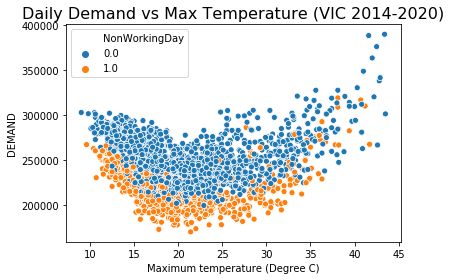

In [39]:
ax1 = plt.subplot();
sns.scatterplot(data=VIC_14_20_d,
               y="DEMAND",
               x="Maximum temperature (Degree C)",
               hue="NonWorkingDay",
               ax=ax1)

ax1.set_title("Daily Demand vs Max Temperature (VIC 2014-2020)", fontdict={'size':16})
plt.show()

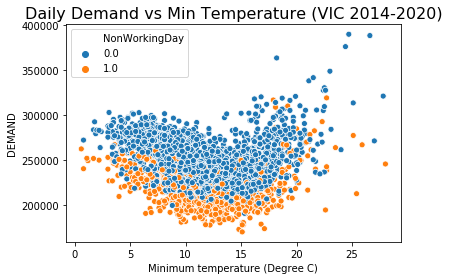

In [40]:
ax1 = plt.subplot();
sns.scatterplot(data=VIC_14_20_d,
               y="DEMAND",
               x="Minimum temperature (Degree C)",
               hue="NonWorkingDay",
               ax=ax1)

ax1.set_title("Daily Demand vs Min Temperature (VIC 2014-2020)", fontdict={'size':16})
plt.show()

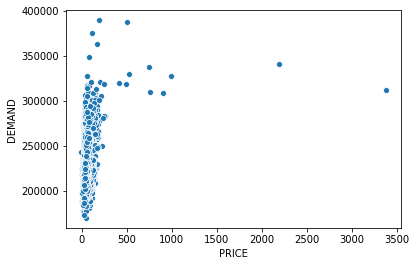

In [41]:
ax2 = plt.subplot();
sns.scatterplot(data=VIC_14_20_d,
               y="DEMAND",
               x="PRICE",
               ax=ax2)

ax1.set_title("Daily Demand vs Price (VIC 2014-2020)", fontdict={'size':16})
plt.show()

In [42]:
VIC_14_20_d.isna().sum()

DEMAND                                  0
PRICE                                   0
Day                                     0
Month                                   0
Year                                    0
Holiday                                 0
isWeekend                               0
NonWorkingDay                           0
Minimum temperature (Degree C)          0
Maximum temperature (Degree C)          0
Rainfall amount (millimetres)           0
Daily global solar exposure (MJ/m*m)    0
dtype: int64

In [43]:
VIC_14_20_d['Year'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020])

## Model Selection

In [44]:
##
# Train test split sequential
# 
# @params: data, dataframe to use
# @params: train_start, string of year to start training data
# @params: train_end, string of year to end training data
# @params: test_year, string of year for testing
# @return, X_train, y_train, X_test, y_test
##
def yearSplit(data, train_start, train_end, test_year):
    X = data.drop(labels='DEMAND',axis = 1)
    y = data['DEMAND']
    X_train = X[train_start:train_end]
    X_test = X[test_year]
    y_train = y[train_start:train_end]
    y_test = y[test_year]
    
    return X_train, y_train, X_test, y_test

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
def evaluate(mdl, mdl_name, X_test, y_test):
    y_pred = mdl.predict(X_test)
    print("******* Numerical Evaluation *********")
    print("R2 score: {}".format(mdl.score(X_test, y_test)))
    print("MAE score: {}".format(mae(y_test, y_pred)))
    print("MAPE score {}".format(mean_absolute_percentage_error(y_test, y_pred)))
    print("**************************************")
    # plot results
    fig = plt.figure(figsize=(15,15), constrained_layout=True)
    fig.suptitle(mdl_name, y = 1.02, x = 0.55, size = 'xx-large')
    gs = fig.add_gridspec(3, 2)
    
    ax1 = fig.add_subplot(gs[0, :])
    ax1.set_title("Predicted vs Actual")
    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title("Residual over time")
    ax3 = fig.add_subplot(gs[2, 0])
    ax3.set_title("Distribution of Residuals")
    ax4 = fig.add_subplot(gs[2, 1])
    ax4.set_title("Residual outliers")

    # data prep for line graph
    res_df = pd.DataFrame(columns=['actual', 'predicted'])
    res_df['actual'] = y_test
    res_df['predicted'] = y_pred
    # plot data
    res_df.plot(ax = ax1)

    
    # data prep for residual scatter plot
    residuals = y_test - y_pred
    residuals_df = pd.DataFrame(residuals)
    # plot data
    residuals_df.reset_index().plot.scatter(x="index", y="DEMAND", ax = ax2)
    
    # residual plots
    sns.distplot(residuals_df['DEMAND'], ax = ax3)
    residuals_df['DEMAND'].plot.box(ax = ax4)
    
    plt.show()
    
    # Residual outliers
    q1 = residuals_df['DEMAND'].quantile(q=0.25)
    q3 = residuals_df['DEMAND'].quantile(q=0.75)
    outliers = residuals_df[(residuals_df['DEMAND'] <= 3*q1) | (residuals_df['DEMAND'] >= 3*q3)]
    print("******* RESIDUAL OUTLIERS ********")
    print(outliers['DEMAND'].abs().sort_values(ascending = False))
    
    return residuals_df

In [47]:
# prepare pre-processing pipeline
stdScaler = StandardScaler()

oheScaler = OneHotEncoder(handle_unknown='ignore')

### Random Forest Regression

In [48]:
VIC_14_20_d.columns

Index(['DEMAND', 'PRICE', 'Day', 'Month', 'Year', 'Holiday', 'isWeekend',
       'NonWorkingDay', 'Minimum temperature (Degree C)',
       'Maximum temperature (Degree C)', 'Rainfall amount (millimetres)',
       'Daily global solar exposure (MJ/m*m)'],
      dtype='object')

#### Time variables + 7 day rolling average and SD of Demand

In [49]:
# data preparation
rfr_data_t = VIC_14_20_d[['DEMAND', 'Day','Month','Year','NonWorkingDay']]

# add time statistics
rfr_data_t['Qtr'] = rfr_data_t.index.quarter
rfr_data_t[["movave_7", "movstd_7"]] = rfr_data_t['DEMAND'].rolling(7).agg([np.mean, np.std])
#data[["movave_30", "movstd_30"]] = data['DEMAND'].rolling(30).agg([np.mean, np.std])
#data[["movave_90", "movstd_90"]] = data['DEMAND'].rolling(90).agg([np.mean, np.std])
#data[["movave_365", "movstd_365"]] = data['DEMAND'].rolling(365).agg([np.mean, np.std])
rfr_data_t.dropna(inplace=True)
rfr_data_t.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

DEMAND  Day  Month  Year  NonWorkingDay  Qtr       movave_7  \
index                                                                        
2014-01-07  235538.82    7      1  2014            0.0    1  219648.417143   
2014-01-08  240624.76    8      1  2014            0.0    1  224529.281429   
2014-01-09  266060.40    9      1  2014            0.0    1  229617.514286   
2014-01-10  299113.19   10      1  2014            0.0    1  239966.125714   
2014-01-11  245757.71   11      1  2014            1.0    1  245302.892857   

                movstd_7  
index                     
2014-01-07  13477.439548  
2014-01-08  14077.920020  
2014-01-09  21204.404652  
2014-01-10  33588.397300  
2014-01-11  30569.207369

******* Numerical Evaluation *********
R2 score: 0.663520156672705
MAE score: 10861.307944109567
MAPE score 4.559412622340464
**************************************


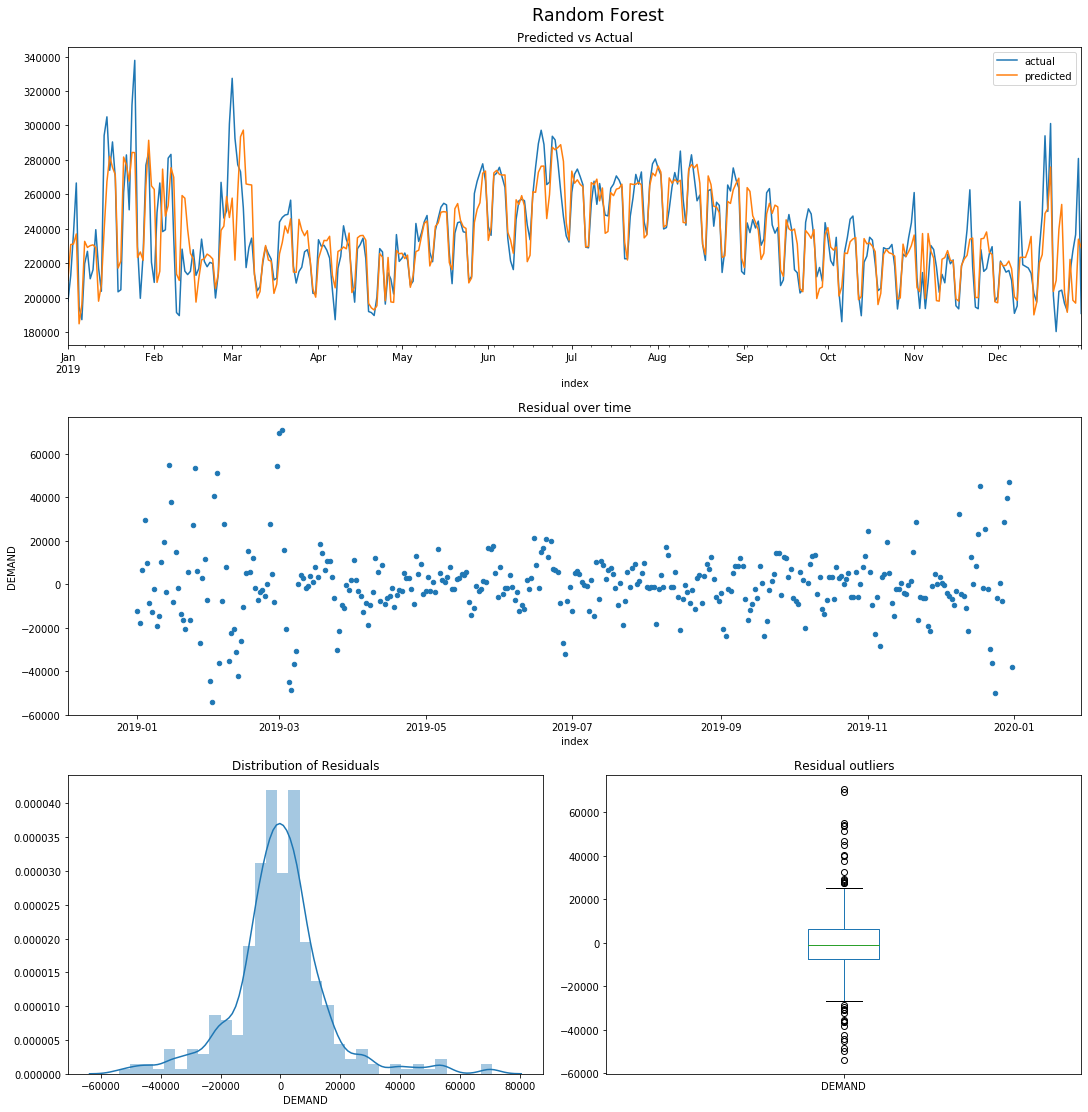

******* RESIDUAL OUTLIERS ********
index
2019-03-02    70748.10891
2019-03-01    69565.58274
2019-01-14    54935.69984
2019-02-28    54415.11019
2019-02-01    53997.25429
2019-01-25    53566.96209
2019-02-03    51241.48180
2019-12-24    49781.24787
2019-03-06    48566.43794
2019-12-30    46859.24678
2019-03-05    45152.92509
2019-12-18    45081.77588
2019-01-31    44354.35874
2019-02-12    42348.21975
2019-02-02    40627.83235
2019-12-29    39769.54352
2019-12-31    38154.62399
2019-01-15    37668.98952
2019-03-07    36626.64161
2019-02-04    36297.03090
2019-12-23    36098.57859
2019-02-08    35261.48474
2019-12-09    32473.87157
2019-06-28    32070.58033
2019-02-11    31117.67373
2019-03-08    30858.31814
2019-03-25    30298.81504
2019-12-22    29709.50030
2019-01-04    29582.10415
2019-11-21    28706.72934
2019-12-28    28542.81205
2019-11-06    28475.71771
2019-02-25    27870.65781
2019-02-06    27592.75878
2019-01-24    27475.02956
2019-01-27    26891.14198
2019-06-27    26765.830

In [50]:
## Model Evaluation

# Feature Selection
dateCols = ['Month', 'Day','Year','Qtr','NonWorkingDay']
metricCols = ['movave_7', 'movstd_7']

# Initialise model pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('metrics', stdScaler, metricCols),
        ('dates', oheScaler, dateCols)])

rfr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=1000))])

# train test split
X_train, y_train, X_test, y_test = yearSplit(rfr_data_t, "2014","2018","2019")

# train model
rfr.fit(X_train, y_train)

# evaluate
residuals = evaluate(rfr, "Random Forest" ,X_test, y_test)

#### Time variables + 7 day rolling average and SD of Demand + weather variables

In [51]:
# data preparation
rfr_data_t = VIC_14_20_d[['DEMAND', 'Day','Month','Year','NonWorkingDay',
                         'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                         'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]

# add time satistics
rfr_data_t['Qtr'] = rfr_data_t.index.quarter
rfr_data_t[["movave_7", "movstd_7"]] = rfr_data_t['DEMAND'].rolling(7).agg([np.mean, np.std])
#data[["movave_30", "movstd_30"]] = data['DEMAND'].rolling(30).agg([np.mean, np.std])
#data[["movave_90", "movstd_90"]] = data['DEMAND'].rolling(90).agg([np.mean, np.std])
#data[["movave_365", "movstd_365"]] = data['DEMAND'].rolling(365).agg([np.mean, np.std])
rfr_data_t.dropna(inplace=True)
rfr_data_t.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DEMAND  Day  Month  Year  NonWorkingDay  \
index                                                    
2014-01-07  235538.82    7      1  2014            0.0   
2014-01-08  240624.76    8      1  2014            0.0   
2014-01-09  266060.40    9      1  2014            0.0   
2014-01-10  299113.19   10      1  2014            0.0   
2014-01-11  245757.71   11      1  2014            1.0   

            Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
index                                                                        
2014-01-07                            14.0                            19.2   
2014-01-08                            11.7                            27.2   
2014-01-09                            13.4                            32.3   
2014-01-10                            18.7                            34.3   
2014-01-11                            17.3                            21.1   

            Rainfall amount (millimetres)  \
index                                       
2014-01-07                            0.0   
2014-01-08                            0.0   
2014-01-09                            0.0   
2014-01-10                            0.0   
2014-01-11                            0.0   

            Daily global solar exposure (MJ/m*m)  Qtr       movave_7  \
index                                                                  
2014-01-07                                  22.2    1  219648.417143   
2014-01-08                                  32.7    1  224529.281429   
2014-01-09                                  27.5    1  229617.514286   
2014-01-10                                  27.9    1  239966.125714   
2014-01-11                                  20.3    1  245302.892857   

                movstd_7  
index                     
2014-01-07  13477.439548  
2014-01-08  14077.920020  
2014-01-09  21204.404652  
2014-01-10  33588.397300  
2014-01-11  30569.207369

******* Numerical Evaluation *********
R2 score: 0.856552242742108
MAE score: 7748.833661479411
MAPE score 3.3316820779173124
**************************************


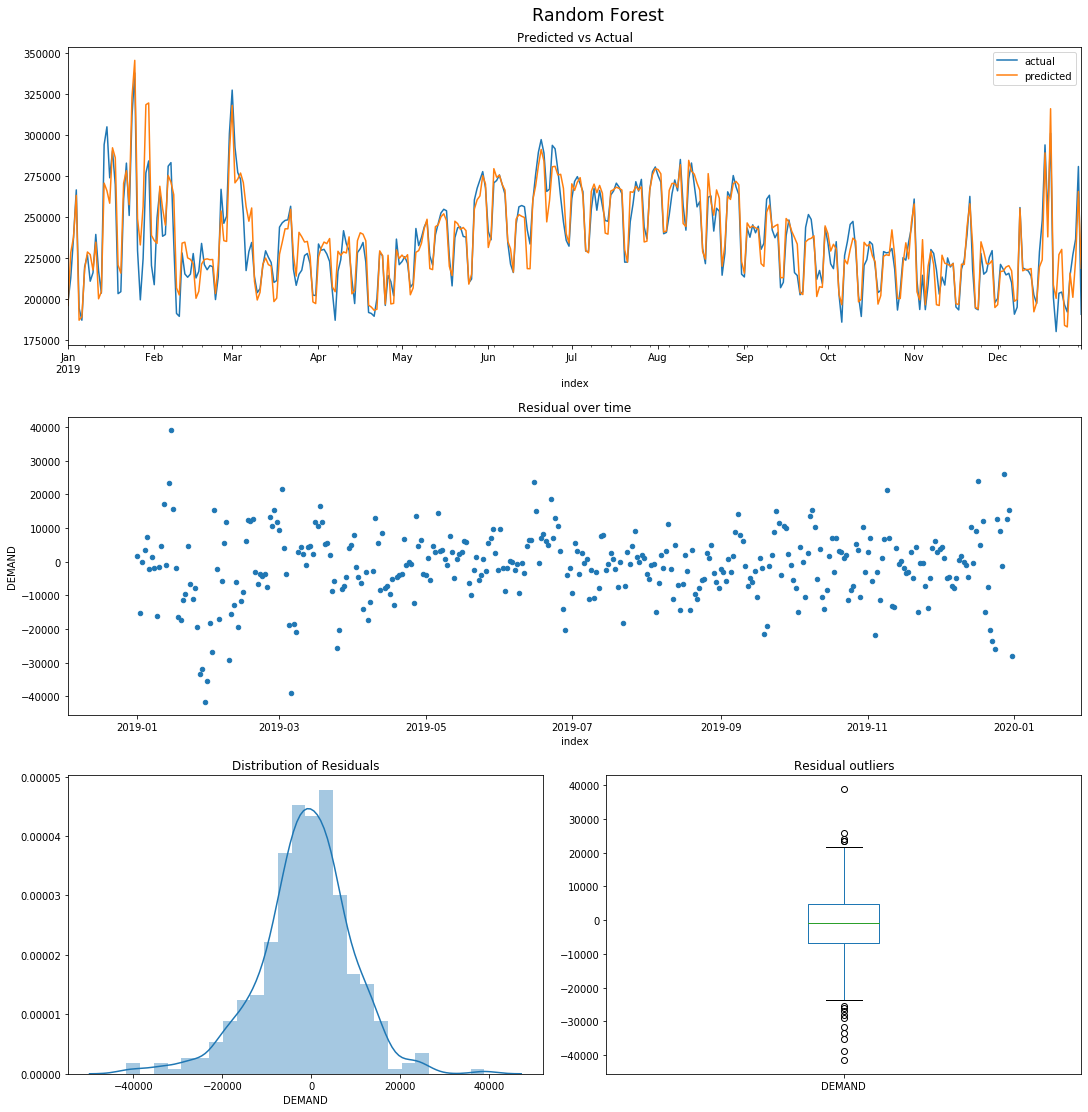

******* RESIDUAL OUTLIERS ********
index
2019-01-29    41555.55281
2019-03-06    38925.82659
2019-01-15    38908.50916
2019-01-30    35306.00328
2019-01-27    33435.46361
2019-01-28    31782.72324
2019-02-08    29034.82098
2019-12-31    28076.29293
2019-02-01    26908.31125
2019-12-24    26017.83752
2019-12-28    25887.69268
2019-03-25    25570.82814
2019-12-17    24033.01774
2019-06-15    23565.87380
2019-12-23    23553.84829
2019-01-14    23467.59482
2019-11-04    21709.15248
2019-03-02    21672.02698
2019-09-19    21425.28694
2019-11-09    21181.48371
2019-03-08    21008.12548
2019-06-28    20419.88984
2019-03-26    20334.71743
2019-06-22    18569.38495
2019-01-12    17007.49905
2019-03-18    16490.05593
2019-01-16    15491.48422
2019-02-02    15467.30657
2019-02-27    15348.40711
2019-10-09    15342.52737
2019-12-30    15206.49209
2019-09-24    15102.17055
2019-06-16    15059.89389
2019-05-06    14516.19436
Name: DEMAND, dtype: float64


In [52]:
## Model Evaluation

# Feature selection
dateCols = ['Month', 'Day','Year','Qtr','NonWorkingDay']
metricCols = ['movave_7', 'movstd_7',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']

# Model pipeline initialisation
preprocessor = ColumnTransformer(
    transformers=[
        ('metrics', stdScaler, metricCols),
        ('dates', oheScaler, dateCols)])

rfr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=1000))])

# train test split
X_train, y_train, X_test, y_test = yearSplit(rfr_data_t, "2014","2018","2019")

# train model
rfr.fit(X_train, y_train)

# evaluate
residuals = evaluate(rfr, "Random Forest", X_test, y_test)

#### Time variables + 7 day rolling average and SD of Demand + weather variables (w/ 7 day statistics)

In [53]:
# data preparation
rfr_data_t = VIC_14_20_d[['DEMAND', 'Day','Month','NonWorkingDay',#'Holiday','isWeekend',
                         'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                         'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]

# add time satistics
#rfr_data_t['Week'] = rfr_data_t.index.week
#rfr_data_t['Weekday'] = rfr_data_t.index.dayofweek
rfr_data_t['DayOfWeek'] = rfr_data_t.index.dayofweek
rfr_data_t[["movave_7", "movstd_7"]] = rfr_data_t['DEMAND'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_7", "maxtempstd_7"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["mintempave_7", "mintempstd_7"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_30", "maxtempstd_30"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
rfr_data_t[["mintempave_30", "mintempstd_30"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
#rfr_data_t[["movave_30", "movstd_30"]] = rfr_data_t['DEMAND'].rolling(30).agg([np.mean, np.std])
#rfr_data_t[["movave_90", "movstd_90"]] = rfr_data_t['DEMAND'].rolling(90).agg([np.mean, np.std])
#rfr_data_t[["movave_365", "movstd_365"]] = rfr_data_t['DEMAND'].rolling(365).agg([np.mean, np.std])
rfr_data_t['Ave_Temp'] = (rfr_data_t['Maximum temperature (Degree C)'] + rfr_data_t['Minimum temperature (Degree C)'])/2
rfr_data_t[["Ave_Temp_ave_7", "Ave_Temp_sd_7"]] = rfr_data_t['Ave_Temp'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["Ave_Temp_ave_30", "Ave_Temp_sd_30"]] = rfr_data_t['Ave_Temp'].rolling(30).agg([np.mean, np.std])
rfr_data_t.dropna(inplace=True)
rfr_data_t.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DEMAND  Day  Month  NonWorkingDay  \
index                                              
2014-01-30  301846.16   30      1            0.0   
2014-01-31  303148.67   31      1            0.0   
2014-02-01  286063.95    1      2            1.0   
2014-02-02  308574.23    2      2            1.0   
2014-02-03  305431.19    3      2            0.0   

            Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
index                                                                        
2014-01-30                            15.0                            28.1   
2014-01-31                            18.4                            24.8   
2014-02-01                            18.1                            27.7   
2014-02-02                            18.1                            38.1   
2014-02-03                            21.8                            34.6   

            Rainfall amount (millimetres)  \
index                                       
2014-01-30                            0.0   
2014-01-31                            0.0   
2014-02-01                            0.0   
2014-02-02                            0.0   
2014-02-03                            0.0   

            Daily global solar exposure (MJ/m*m)  DayOfWeek       movave_7  \
index                                                                        
2014-01-30                                  27.8          3  274473.982857   
2014-01-31                                  27.2          4  279615.737143   
2014-02-01                                  27.6          5  288814.164286   
2014-02-02                                  29.7          6  300400.802857   
2014-02-03                                   7.4          0  305211.655714   

            ...  mintempstd_7  maxtempave_30  maxtempstd_30  mintempave_30  \
index       ...                                                              
2014-01-30  ...      3.430674      27.423333       7.906814      16.470000   
2014-01-31  ...      3.495644      27.366667       7.919741      16.566667   
2014-02-01  ...      3.427549      27.563333       7.849686      16.670000   
2014-02-02  ...      2.428599      28.113333       7.994167      16.830000   
2014-02-03  ...      2.675818      28.573333       7.955780      17.110000   

            mintempstd_30  Ave_Temp  Ave_Temp_ave_7  Ave_Temp_sd_7  \
index                                                                
2014-01-30       4.068224     21.55       22.200000       5.075349   
2014-01-31       4.078821     21.60       22.550000       4.911806   
2014-02-01       4.077030     22.90       23.378571       4.288925   
2014-02-02       4.034177     28.10       24.607143       4.223982   
2014-02-03       4.079161     28.20       24.964286       4.432335   

            Ave_Temp_ave_30  Ave_Temp_sd_30  
index                                        
2014-01-30        21.946667        5.479317  
2014-01-31        21.966667        5.476837  
2014-02-01        22.116667        5.437265  
2014-02-02        22.471667        5.469645  
2014-02-03        22.841667        5.469178  

[5 rows x 24 columns]

******* Numerical Evaluation *********
R2 score: 0.8852631916837952
MAE score: 7166.245603692302
MAPE score 3.0897150544251706
**************************************


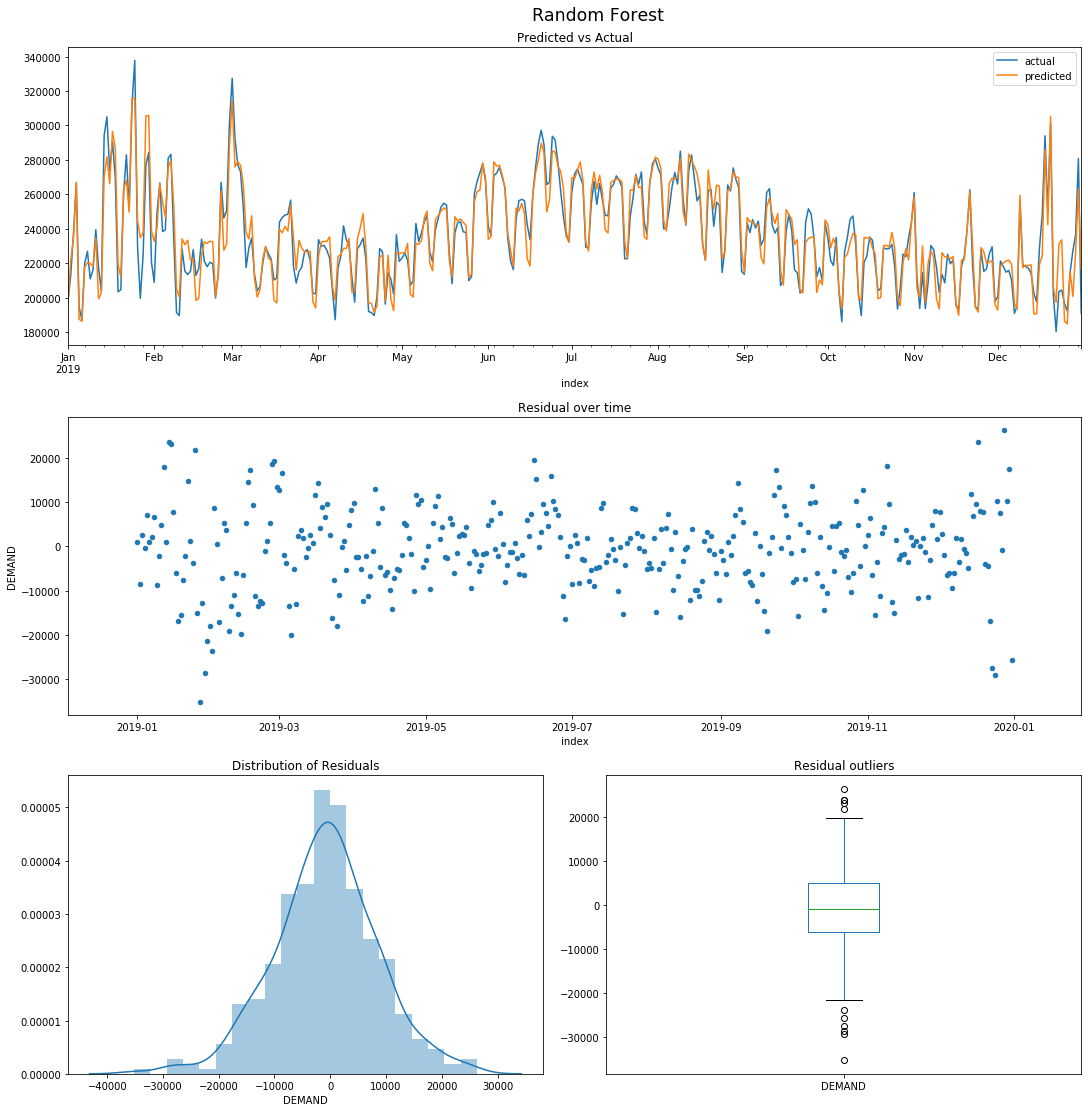

******* RESIDUAL OUTLIERS ********
index
2019-01-27    35218.041036
2019-12-24    29194.064060
2019-01-29    28617.320762
2019-12-23    27563.236792
2019-12-28    26296.354861
2019-12-31    25685.251436
2019-02-01    23821.524926
2019-01-14    23733.197475
2019-12-17    23704.297100
2019-01-15    23219.299236
2019-01-25    21835.503487
2019-01-30    21524.240908
2019-03-06    20134.617708
2019-02-13    19955.145710
2019-06-15    19678.064488
2019-02-27    19487.184838
2019-02-08    19256.383702
2019-09-20    19145.333446
2019-02-26    18746.775434
2019-11-09    18327.613344
2019-01-12    17952.114813
2019-12-30    17463.628874
2019-02-17    17388.657947
2019-09-24    17241.033956
2019-03-02    16736.781366
2019-06-22    15872.289666
2019-06-16    15318.739429
2019-01-22    14806.743004
Name: DEMAND, dtype: float64


In [54]:
## Model evaluation

# Feature selection
dateCols = ['Month', 'Day','NonWorkingDay','DayOfWeek']
metricCols = ['movave_7', 'movstd_7', #'movave_30', 'movstd_30',
             # 'movave_90', 'movstd_90', 'movave_365', 'movstd_365',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Daily global solar exposure (MJ/m*m)',
              'maxtempave_7', 'maxtempstd_7','mintempave_7', 'mintempstd_7',
             #'maxtempave_30', 'maxtempstd_30','mintempave_30', 'mintempstd_30',
              'Ave_Temp']#, "Ave_Temp_ave_7", "Ave_Temp_sd_7","Ave_Temp_ave_30", "Ave_Temp_sd_30"]

# Model pipeline initalisation
#preprocessor = ColumnTransformerer(
#    transformers=[
#        ('metrics', stdScaler, metricCols),
#        ('dates', oheScaler, dateCols)])

#rfr = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('regressor', RandomForestRegressor(n_estimators=500))])

rfr = RandomForestRegressor(n_estimators=500, 
                            criterion='mse', 
                            max_features='auto', 
                            min_samples_leaf=2, 
                            min_samples_split=2)

# train test split
X_train, y_train, X_test, y_test = yearSplit(rfr_data_t, "2014","2018","2019")

# train model
rfr.fit(X_train, y_train)

# evaluate
residuals = evaluate(rfr, "Random Forest", X_test, y_test)

******* Numerical Evaluation *********
R2 score: 0.8827466044175061
MAE score: 7283.152606253537
MAPE score 3.1738077402343174
**************************************


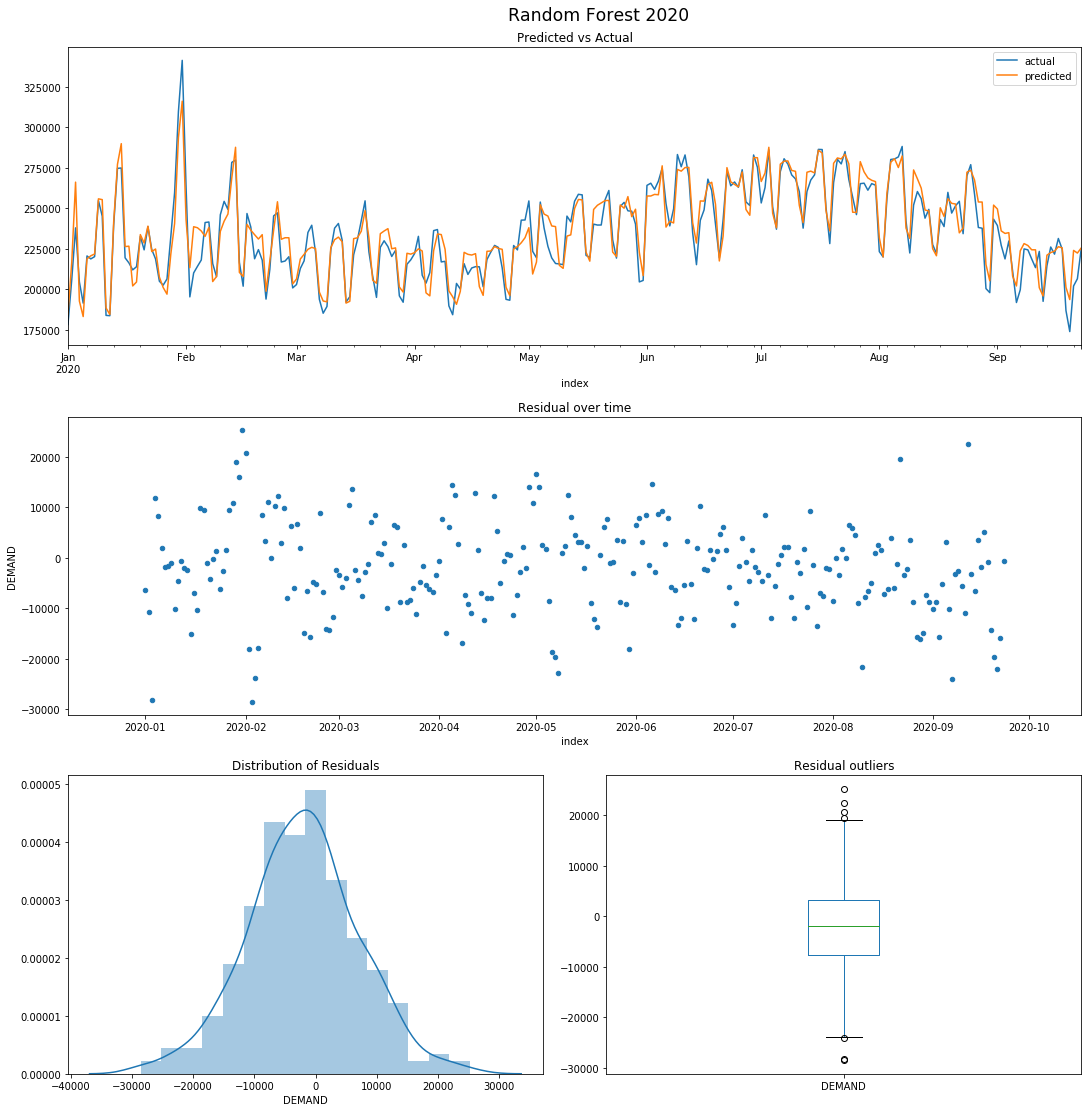

******* RESIDUAL OUTLIERS ********
index
2020-02-03    28544.016830
2020-01-03    28237.246962
2020-01-31    25213.168496
2020-09-07    24112.077272
2020-02-04    23850.778382
2020-09-12    22438.015235
2020-02-01    20721.185532
2020-08-22    19485.122775
2020-01-29    19061.914317
2020-05-01    16543.384346
2020-01-30    16039.404329
2020-06-06    14534.192410
2020-04-05    14368.938596
2020-05-02    13992.004882
2020-04-29    13984.252230
2020-03-05    13649.899692
2020-04-12    12898.919647
2020-04-06    12437.832192
2020-05-11    12349.176999
2020-02-11    12254.244510
2020-04-18    12237.160911
2020-01-04    11861.898893
2020-02-08    11048.931041
2020-04-30    10926.715447
2020-01-28    10856.911048
2020-03-04    10414.480366
2020-02-10    10311.026264
2020-06-21    10261.786929
2020-01-18     9917.581948
2020-02-13     9765.058846
2020-01-19     9436.901811
Name: DEMAND, dtype: float64


In [55]:
residuals = evaluate(rfr, "Random Forest 2020", rfr_data_t['2020'].drop('DEMAND',axis = 1), rfr_data_t['2020']['DEMAND'])

In [56]:
VIC_14_20_d['DEMAND'].pct_change(365)['2019-01-26':'2019-01-29']

index
2019-01-26   -0.107161
2019-01-27   -0.282594
2019-01-28   -0.295177
2019-01-29   -0.137013
Freq: D, Name: DEMAND, dtype: float64

In [57]:
VIC_14_20_d['DEMAND'].pct_change(365)['2018-01-26':'2018-01-29']

index
2018-01-26    0.304386
2018-01-27    0.236422
2018-01-28    0.471680
2018-01-29    0.471626
Freq: D, Name: DEMAND, dtype: float64

******* Numerical Evaluation *********
R2 score: 0.983054991598382
MAE score: 2573.795111699338
MAPE score 1.065225117711243
**************************************


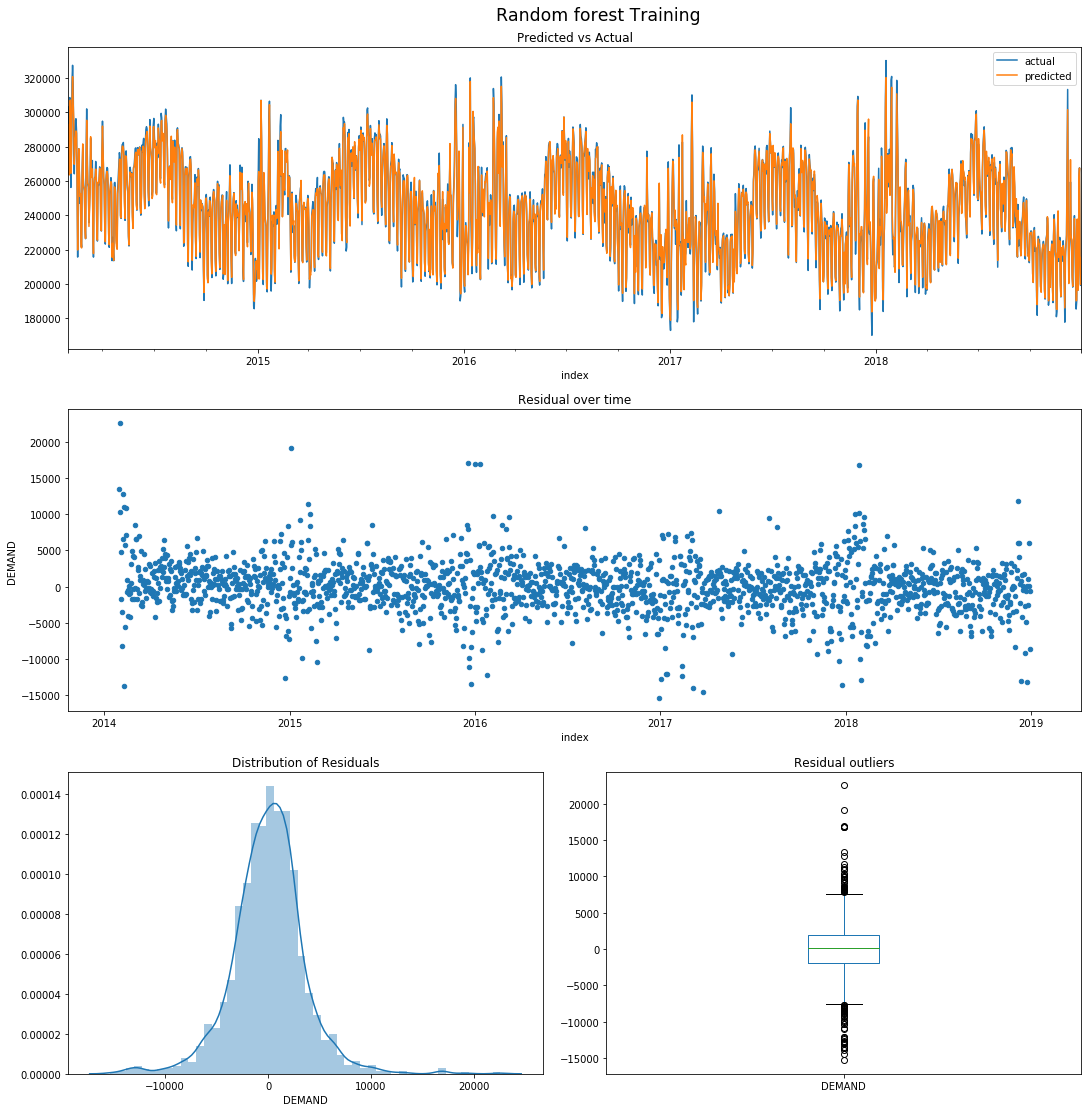

******* RESIDUAL OUTLIERS ********
index
2014-02-01    22561.893885
2015-01-03    19128.446177
2015-12-19    16994.480757
2016-01-01    16887.592605
2016-01-12    16834.573204
                  ...     
2015-02-13     5742.540446
2015-12-11     5738.831367
2017-12-02     5734.650336
2014-09-07     5721.956778
2016-10-30     5698.821440
Name: DEMAND, Length: 170, dtype: float64


In [58]:
# evaluate
residuals_train = evaluate(rfr, "Random forest Training",X_train, y_train)

### XGBoost

In [59]:
# data preparation
data = VIC_14_20_d[['DEMAND', 'Day','Month','NonWorkingDay',
                 'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                 'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]
# add features
data['DayOfWeek'] = data.index.dayofweek
data[["movave_7", "movstd_7"]] = data['DEMAND'].rolling(7).agg([np.mean, np.std])
data[["maxtempave_7", "maxtempstd_7"]] = data['Maximum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
data[["mintempave_7", "mintempstd_7"]] = data['Minimum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
data[["maxtempave_30", "maxtempstd_30"]] = data['Maximum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
data[["mintempave_30", "mintempstd_30"]] = data['Minimum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
data['Ave_Temp'] = (data['Maximum temperature (Degree C)'] + data['Minimum temperature (Degree C)'])/2
data[["Ave_Temp_ave_7", "Ave_Temp_sd_7"]] = data['Ave_Temp'].rolling(7).agg([np.mean, np.std])
data[["Ave_Temp_ave_30", "Ave_Temp_sd_30"]] = data['Ave_Temp'].rolling(30).agg([np.mean, np.std])
data.dropna(inplace=True)

data.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DEMAND  Day  Month  NonWorkingDay  \
index                                              
2014-01-30  301846.16   30      1            0.0   
2014-01-31  303148.67   31      1            0.0   
2014-02-01  286063.95    1      2            1.0   
2014-02-02  308574.23    2      2            1.0   
2014-02-03  305431.19    3      2            0.0   

            Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
index                                                                        
2014-01-30                            15.0                            28.1   
2014-01-31                            18.4                            24.8   
2014-02-01                            18.1                            27.7   
2014-02-02                            18.1                            38.1   
2014-02-03                            21.8                            34.6   

            Rainfall amount (millimetres)  \
index                                       
2014-01-30                            0.0   
2014-01-31                            0.0   
2014-02-01                            0.0   
2014-02-02                            0.0   
2014-02-03                            0.0   

            Daily global solar exposure (MJ/m*m)  DayOfWeek       movave_7  \
index                                                                        
2014-01-30                                  27.8          3  274473.982857   
2014-01-31                                  27.2          4  279615.737143   
2014-02-01                                  27.6          5  288814.164286   
2014-02-02                                  29.7          6  300400.802857   
2014-02-03                                   7.4          0  305211.655714   

            ...  mintempstd_7  maxtempave_30  maxtempstd_30  mintempave_30  \
index       ...                                                              
2014-01-30  ...      3.430674      27.423333       7.906814      16.470000   
2014-01-31  ...      3.495644      27.366667       7.919741      16.566667   
2014-02-01  ...      3.427549      27.563333       7.849686      16.670000   
2014-02-02  ...      2.428599      28.113333       7.994167      16.830000   
2014-02-03  ...      2.675818      28.573333       7.955780      17.110000   

            mintempstd_30  Ave_Temp  Ave_Temp_ave_7  Ave_Temp_sd_7  \
index                                                                
2014-01-30       4.068224     21.55       22.200000       5.075349   
2014-01-31       4.078821     21.60       22.550000       4.911806   
2014-02-01       4.077030     22.90       23.378571       4.288925   
2014-02-02       4.034177     28.10       24.607143       4.223982   
2014-02-03       4.079161     28.20       24.964286       4.432335   

            Ave_Temp_ave_30  Ave_Temp_sd_30  
index                                        
2014-01-30        21.946667        5.479317  
2014-01-31        21.966667        5.476837  
2014-02-01        22.116667        5.437265  
2014-02-02        22.471667        5.469645  
2014-02-03        22.841667        5.469178  

[5 rows x 24 columns]

******* Numerical Evaluation *********
R2 score: 0.8887225548144839
MAE score: 6820.1268904109575
MAPE score 2.9173798785356886
**************************************


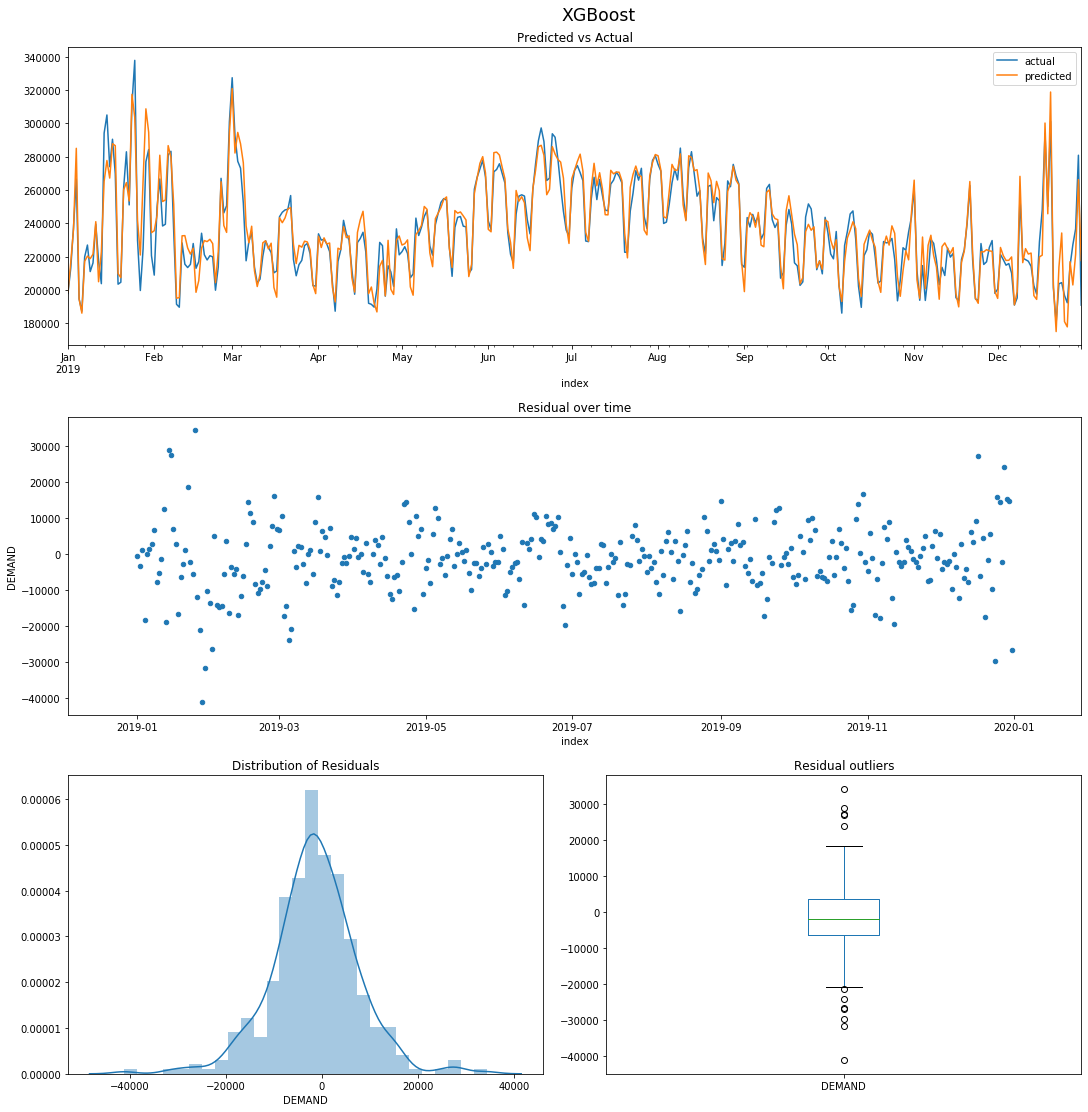

******* RESIDUAL OUTLIERS ********
index
2019-01-28    41167.115000
2019-01-25    34264.252500
2019-01-29    31768.621250
2019-12-24    29790.515000
2019-01-14    28869.413750
2019-01-15    27340.115000
2019-12-17    27178.843125
2019-12-31    26782.423125
2019-02-01    26641.373125
2019-12-28    24107.666875
2019-03-05    24097.127500
2019-01-27    21311.756250
2019-03-06    20915.941875
2019-06-28    19938.603750
2019-11-12    19576.017500
2019-01-13    19114.801250
2019-01-22    18483.935000
2019-10-30    16732.819375
2019-02-27    16052.071250
2019-03-17    15747.558750
2019-12-25    15689.974375
2019-12-29    15283.690625
2019-12-30    14657.125000
2019-09-01    14621.871875
2019-12-26    14476.300000
2019-02-16    14411.251250
2019-04-23    14318.754375
2019-04-22    13750.535625
2019-10-28    13742.348125
2019-09-25    12825.281875
2019-05-05    12758.675625
2019-01-12    12378.248125
2019-09-24    12247.128750
2019-02-17    11384.209375
2019-06-15    10908.846250
Name: DEMAND, 

In [60]:
## Model Evaluation

## Feature selection
dateCols = ['Month', 'Day','NonWorkingDay','DayOfWeek']
metricCols = ['movave_7', 'movstd_7','Ave_Temp',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Daily global solar exposure (MJ/m*m)',
              'maxtempave_7', 'maxtempstd_7','mintempave_7', 'mintempstd_7']

# Model pipeline initialisation
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('metrics', stdScaler, metricCols),
#        ('dates', oheScaler, dateCols)])

#xgb = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('regressor', XGBRegressor(n_estimators=1000))])

xgb = XGBRegressor()

# train test split
X_train, y_train, X_test, y_test = yearSplit(data, "2014","2018","2019")

# train model
xgb.fit(X_train, y_train)

# evaluate
residuals = evaluate(xgb, "XGBoost", X_test, y_test)

## Hyper-parameter tuning

In [69]:
# prep tuning data using best features
tuning_data = VIC_14_20_d[['DEMAND', 'Day','Month','NonWorkingDay',
                 'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                 'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]

# add features
tuning_data['DayOfWeek'] = tuning_data.index.dayofweek
tuning_data[["movave_7", "movstd_7"]] = tuning_data['DEMAND'].rolling(7).agg([np.mean, np.std])
tuning_data[["maxtempave_7", "maxtempstd_7"]] = tuning_data['Maximum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
tuning_data[["mintempave_7", "mintempstd_7"]] = tuning_data['Minimum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
#tuning_data[["maxtempave_30", "maxtempstd_30"]] = tuning_data['Maximum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
#tuning_data[["mintempave_30", "mintempstd_30"]] = tuning_data['Minimum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
tuning_data['Ave_Temp'] = (tuning_data['Maximum temperature (Degree C)'] + tuning_data['Minimum temperature (Degree C)'])/2
tuning_data[["Ave_Temp_ave_7", "Ave_Temp_sd_7"]] = tuning_data['Ave_Temp'].rolling(7).agg([np.mean, np.std])
tuning_data[["Ave_Temp_ave_30", "Ave_Temp_sd_30"]] = tuning_data['Ave_Temp'].rolling(30).agg([np.mean, np.std])
tuning_data.dropna(inplace=True)

## Feature selection
dateCols = ['Month', 'Day','NonWorkingDay','DayOfWeek']
metricCols = ['movave_7', 'movstd_7','Ave_Temp',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Daily global solar exposure (MJ/m*m)',
              'maxtempave_7', 'maxtempstd_7','mintempave_7', 'mintempstd_7']

# Preprocessing pipeline initialisation
preprocessor = ColumnTransformer(
    transformers=[
        ('metrics', stdScaler, metricCols),
        ('dates', oheScaler, dateCols)])

# train test split (use X_train and y_train for tuning)
X_train, y_train, X_test, y_test = yearSplit(data, "2014","2018","2019")

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [84]:
## Grid Search
def GridSearch_report(param_grid, clf, X, y):

    grid_search = GridSearchCV(clf, param_grid, scoring = 'neg_mean_absolute_error',cv=10, )
    grid_search.fit(X,y)
    res = pd.DataFrame(grid_search.cv_results_)
    print(res.sort_values(by='rank_test_score').head())
    print("Best Score: %.2f" % grid_search.best_score_)
    print("Best Parameters : %s" % grid_search.best_params_)
    
    return grid_search

### Random Forest Optimisation

In [155]:
# parameters to test
rfr_parameters = {'criterion'   : ("mse", "mae"),
                  'max_features': ("auto", "sqrt", "log2"),
                  'min_samples_split' : list(range(2,6)),
                  'min_samples_leaf' : list(range(1,5))
                 }
# model initialisation
rfr = RandomForestRegressor(n_estimators=1000)

GridSearch_report(rfr_parameters, rfr, X_train, y_train)

Best average recall: -7068.15
Parameters : {'criterion': 'mse', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}


Best parameter set
Best average recall: -7068.15
Parameters : {'criterion': 'mse', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}

In [171]:
# test for overfitting
mape  = []
for i in range(100,1000,50):
    rfr = RandomForestRegressor(n_estimators=i, 
                                criterion="mse",
                                max_features="auto",
                                min_samples_split=2,
                                min_samples_leaf=2)
    rfr.fit(X_train,y_train)
    train_mape = mean_absolute_percentage_error(y_train, rfr.predict(X_train))
    test_mape = mean_absolute_percentage_error(y_test, rfr.predict(X_test))
    
    mape.append([train_mape, test_mape])

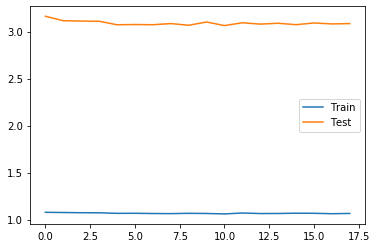

In [172]:
mape_df = pd.DataFrame(mape, columns=["Train","Test"])
mape_df.plot()

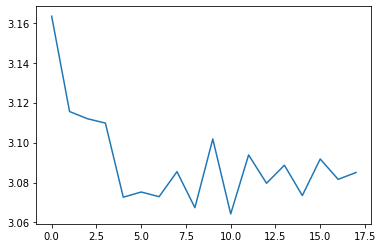

In [173]:
mape_df['Test'].plot()

In [62]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1797 entries, 2014-01-30 to 2018-12-31
Freq: D
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Day                                   1797 non-null   int64  
 1   Month                                 1797 non-null   int64  
 2   NonWorkingDay                         1797 non-null   float64
 3   Minimum temperature (Degree C)        1797 non-null   float64
 4   Maximum temperature (Degree C)        1797 non-null   float64
 5   Rainfall amount (millimetres)         1797 non-null   float64
 6   Daily global solar exposure (MJ/m*m)  1797 non-null   float64
 7   DayOfWeek                             1797 non-null   int64  
 8   movave_7                              1797 non-null   float64
 9   movstd_7                              1797 non-null   float64
 10  maxtempave_7                          1797 non-null   floa

### XGBoost parameter tuning

Source: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [63]:
import xgboost as xgb

In [64]:
# prepare model predictors and targets list
target = 'target'
predictors = [x for x in X_train.columns if x not in [target]]
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=1000,
             max_depth=5,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
             seed=27)
# prepare training data for CV
xgb_train_data = X_train
xgb_train_data['target'] = y_train

# Cross validation
# get parameters
param = mdl.get_xgb_params()
# prepare data to use for cv
cv_data = xgb.DMatrix(xgb_train_data.drop(target, axis =1).values, label=xgb_train_data[target].values)
# Cross validation
cv_folds = 5
early_stopping_rounds = 50
cv_result = xgb.cv(param, 
                   cv_data, 
                   num_boost_round=mdl.get_params()['n_estimators'], 
                   nfold=cv_folds,
                   metrics='mae', 
                   early_stopping_rounds=early_stopping_rounds,
                   as_pandas=True)
cv_result
#alg.set_params(n_estimators=cvresult.shape[0])

train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0     220123.628125     114.405597  220118.350000    455.732752
1     198203.525000     104.703351  198183.512500    442.457246
2     178471.943750     104.496711  178451.912500    387.393090
3     160694.187500      95.892992  160706.075000    347.769376
4     144706.575000      80.875747  144730.450000    358.997464
..              ...            ...            ...           ...
337      725.681763      15.910971    5469.665918    170.091607
338      721.923083      15.859526    5469.024121    170.273132
339      717.830542      16.802105    5469.500293    169.765058
340      715.125928      15.172421    5469.442773    169.712615
341      711.620996      14.618047    5468.608008    169.196308

[342 rows x 4 columns]

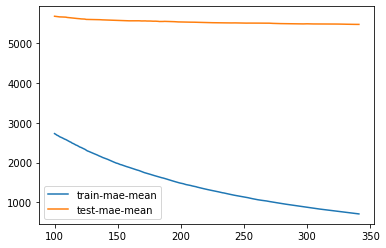

In [65]:
cv_result.iloc[100:][['train-mae-mean', 'test-mae-mean']].plot()

In [98]:
# method to train xgboost using optimal number of trees

def modelfit(mdl, data, label, test_data,
             useTrainCV=True, validate=True, cv_folds=10, early_stopping_rounds=50):
    # prepare data
    features = data.drop(label, axis =1)
    target = data[label]
    
    X_test = test_data.drop(label, axis = 1)
    y_test = test_data[label]
    
    print("Model Parameters")
    print(mdl.get_xgb_params())
    
    # optimise number of trees
    if useTrainCV:
        # get parameters
        param = mdl.get_xgb_params()
        cv_data = xgb.DMatrix(features.values, label=target.values)
        cv_result = xgb.cv(param, 
                   cv_data, 
                   num_boost_round=mdl.get_params()['n_estimators'], 
                   nfold=cv_folds,
                   stratified=False,
                   metrics='mae', 
                   early_stopping_rounds=early_stopping_rounds)
        mdl.set_params(n_estimators=cv_result.shape[0])
        # print cv results
        print(cv_result[-1:])
    
    if validate:
        #Fit the algorithm on the data
        mdl.fit(features, target, eval_metric='mae')

        # Evaluate on test set
        evaluate(mdl, "XGBoost Regressor", X_test, y_test)

#### Learning Rate and n_estimators

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
334      849.215088      19.450522    5370.206543    342.065142
******* Numerical Evaluation *********
R2 score: 0.9150105957179325
MAE score: 6065.351013698629
MAPE score 2.6042041806393175
**************************************


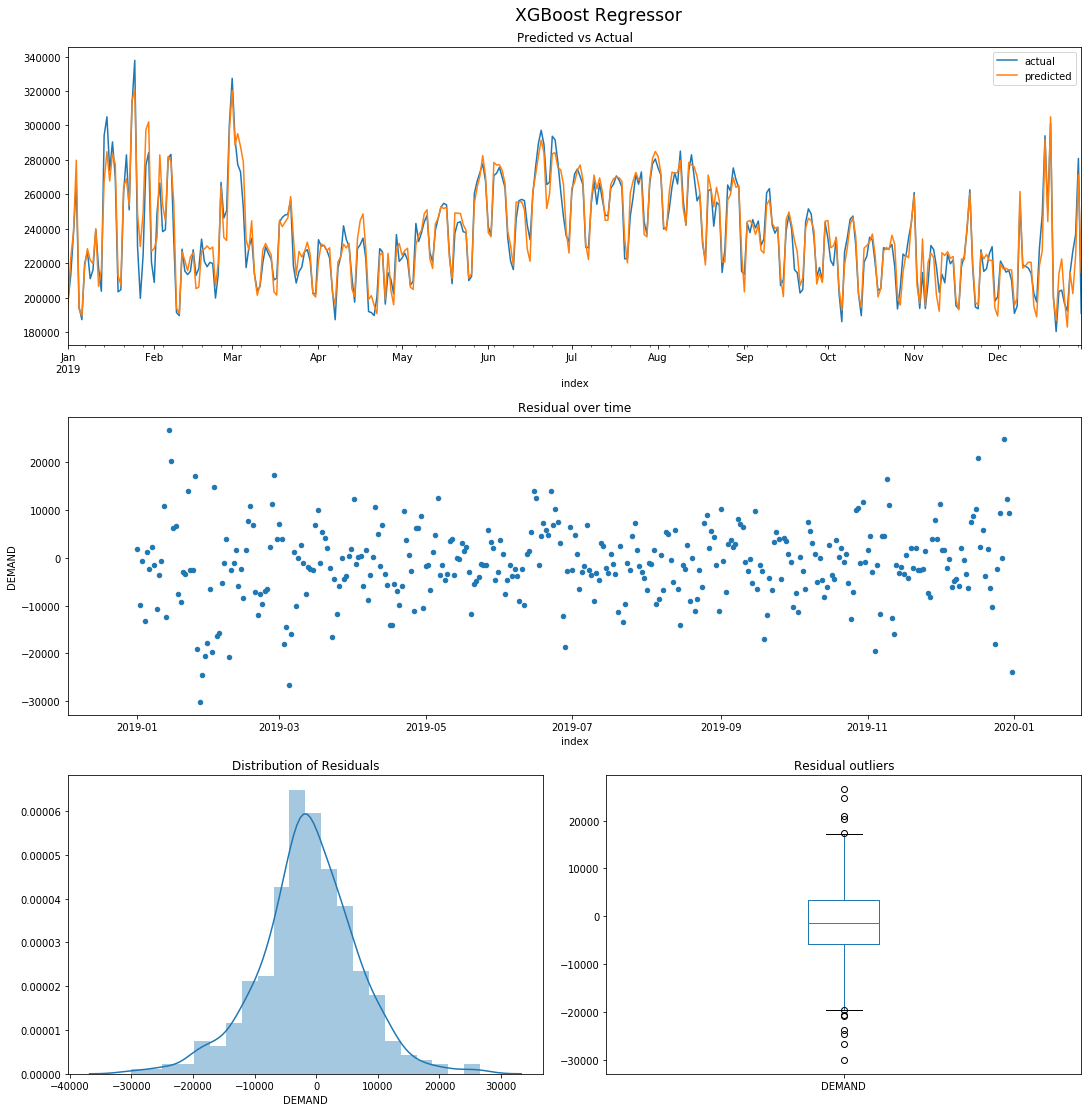

******* RESIDUAL OUTLIERS ********
index
2019-01-27    30100.615625
2019-03-05    26626.127500
2019-01-14    26589.476250
2019-12-28    24725.791875
2019-01-28    24553.365000
2019-12-31    23858.657500
2019-12-17    20886.155625
2019-02-08    20789.463125
2019-01-29    20551.496250
2019-01-15    20230.896250
2019-02-01    19658.123125
2019-11-04    19558.398125
2019-01-26    19136.373125
2019-06-28    18685.603750
2019-12-24    18116.249375
2019-03-03    17999.026250
2019-01-30    17880.875000
2019-02-27    17383.040000
2019-01-25    17177.127500
2019-11-09    16428.830000
2019-02-02    14845.630000
2019-06-15    13966.174375
2019-06-22    13884.658125
2019-01-22    13877.716250
2019-06-16    12491.030000
2019-05-06    12464.970000
2019-04-01    12185.188125
2019-12-29    12180.471875
2019-10-30    11591.444375
2019-02-26    11274.370625
2019-12-01    11169.319375
2019-11-10    11011.761875
2019-02-17    10848.240625
2019-01-12    10707.498125
2019-04-10    10695.647500
Name: DEMAND, 

In [96]:
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=1000,
             max_depth=5,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# prepare training data for CV
xgb_train_data = X_train
xgb_train_data['DEMAND'] = y_train

xgb_test_data = X_test
xgb_test_data['DEMAND'] = y_test

modelfit(mdl, xgb_train_data, 'DEMAND', xgb_test_data)

#### Max Depth and Min Child Weight

In [97]:
# parameters to test
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=341,
             max_depth=5,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

param_test1 = {
     'max_depth':range(3,10,2),
     'min_child_weight':range(0,10,2)
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       0.297244      0.001076         0.002622        0.000122   
8       0.291364      0.002715         0.002721        0.000477   
2       0.187805      0.002471         0.002222        0.000043   
1       0.189994      0.002407         0.002246        0.000049   
5       0.304710      0.003147         0.002624        0.000039   

  param_max_depth param_min_child_weight  \
7               5                      4   
8               5                      6   
2               3                      4   
1               3                      2   
5               5                      0   

                                    params  split0_test_score  \
7  {'max_depth': 5, 'min_child_weight': 4}        -647.410271   
8  {'max_depth': 5, 'min_child_weight': 6}        -664.257882   
2  {'max_depth': 3, 'min_child_weight': 4}        -695.000319   
1  {'max_depth': 3, 'min_child_weight': 2}        -680.806038   
5  {'ma

In [72]:
# parameters to test
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=341,
             max_depth=5,
             min_child_weight=1,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# parameters to test
param_test1 = {
     'max_depth':(4,5,6),
     'min_child_weight':[4,5,6]
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

Best Score: -598.09
Best Parameters : {'max_depth': 4, 'min_child_weight': 4}


#### Gamma

In [73]:
# parameters to test
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=341,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# parameters to test
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

Best Score: -598.09
Best Parameters : {'gamma': 0.0}


Model Parameters
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'gamma': 0, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_delta_step': None, 'max_depth': 4, 'min_child_weight': 4, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': 1, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'nthread': 4, 'seed': 27}
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
201     2461.694629      59.892693    5471.447656    252.551334
******* Numerical Evaluation *********
R2 score: 0.9031759805761266
MAE score: 6453.404422945204
MAPE score 2.775420705932375
**************************************


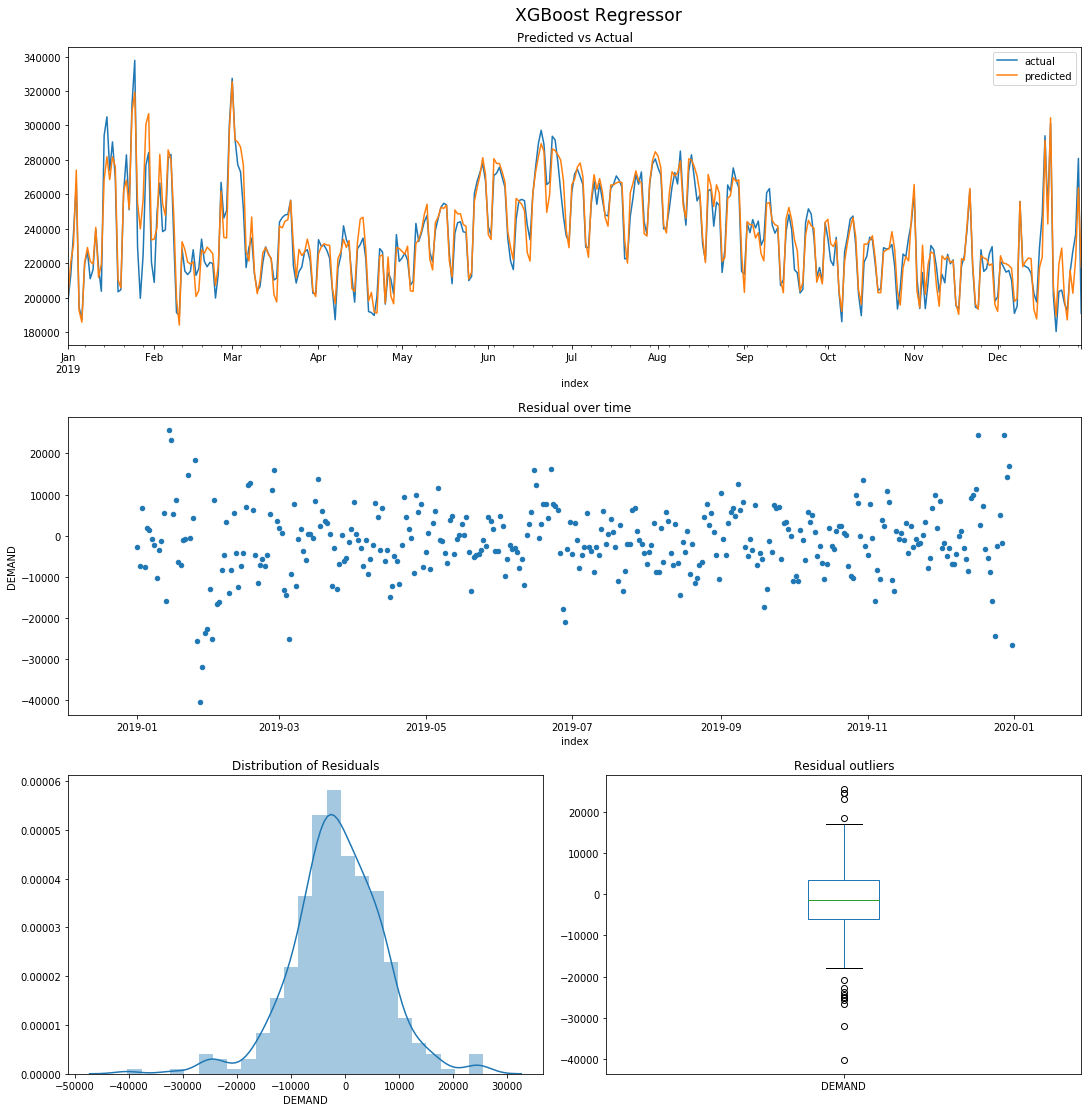

******* RESIDUAL OUTLIERS ********
index
2019-01-27    40305.553125
2019-01-28    31998.521250
2019-12-31    26648.845000
2019-01-26    25659.232500
2019-01-14    25554.351250
2019-02-01    25161.873125
2019-03-05    25059.533750
2019-12-17    24512.936875
2019-12-28    24490.823125
2019-12-24    24439.468125
2019-01-29    23670.246250
2019-01-15    23125.646250
2019-01-30    22668.375000
2019-06-28    20919.197500
2019-01-25    18465.033750
2019-12-30    17044.750000
2019-06-22    16184.330000
2019-06-15    16040.190000
2019-02-27    15936.571250
2019-01-22    14685.091250
2019-12-29    14315.159375
2019-03-17    13859.090000
2019-10-30    13411.475625
2019-02-17    12860.865625
2019-09-08    12600.686875
2019-06-16    12366.842500
2019-02-16    12243.329375
2019-05-06    11575.845000
2019-12-16    11349.505000
2019-02-26    11216.683125
2019-11-09    10980.330000
Name: DEMAND, dtype: float64


In [101]:
# update n_estimators
# parameters to test
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=341,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

modelfit(mdl, xgb_train_data, 'DEMAND', xgb_test_data, 
         useTrainCV=True, cv_folds=5, early_stopping_rounds=10)

#### Sub sample and colsamples

In [75]:
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=361,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=0.8,
             colsample_bytree=0.8,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# parameters to test
param_test1 = {
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)]
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

Best Score: -357.93
Best Parameters : {'colsample_bytree': 1.0, 'subsample': 1.0}


In [199]:
# parameters to test
param_test1 = {
    'subsample':[i/100.0 for i in range(85,100,5)],
    'colsample_bytree':[i/100.0 for i in range(85,100,5)]
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

Best Score: -461.72
Best Parameters : {'colsample_bytree': 0.95, 'subsample': 0.95}


     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
501     1033.234057        25.6671    5373.965918    248.203774
******* Numerical Evaluation *********
R2 score: 0.9047180350897007
MAE score: 6469.693309931506
MAPE score 2.7870392867173863
**************************************


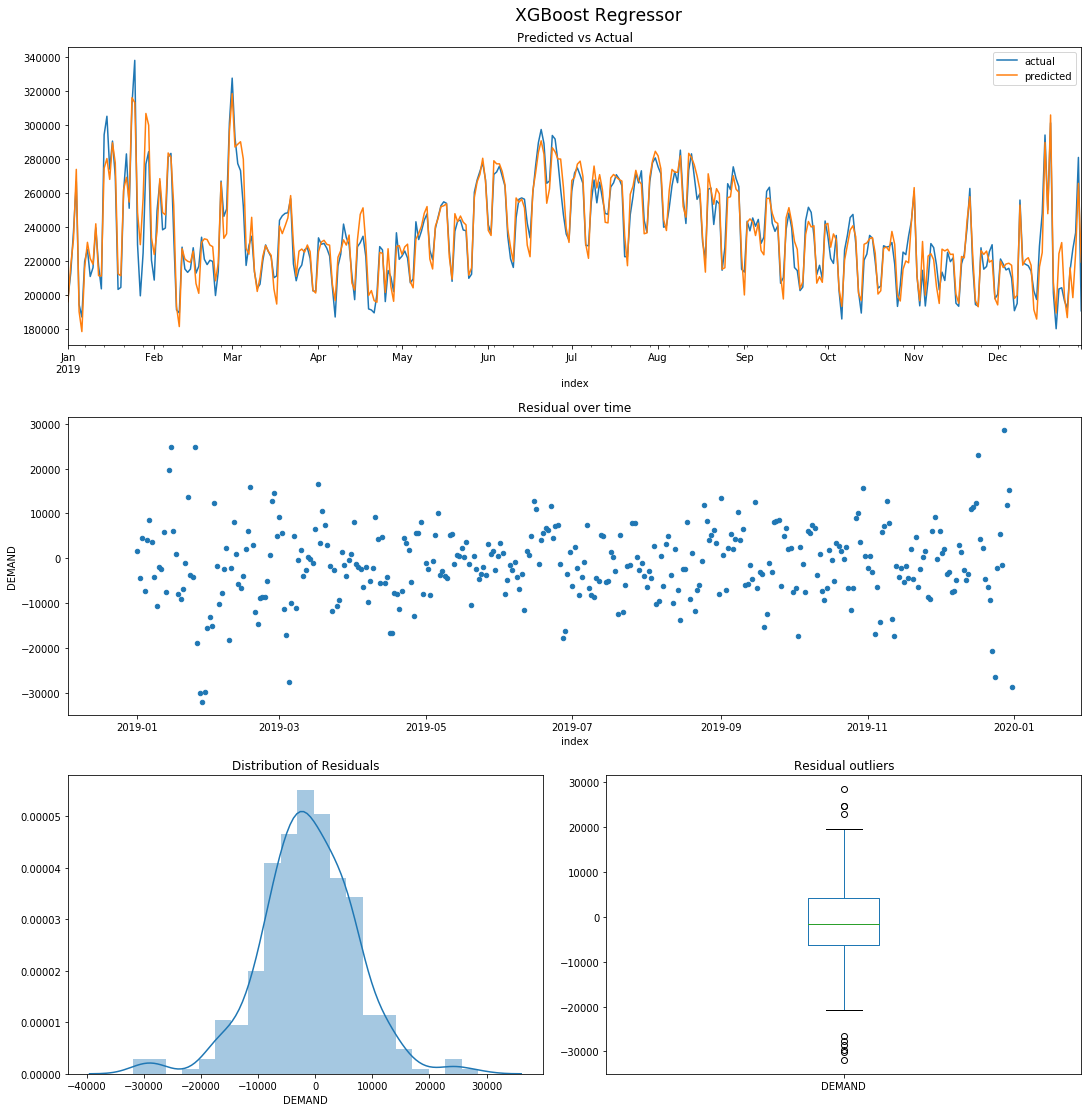

******* RESIDUAL OUTLIERS ********
index
2019-01-28    31961.365000
2019-01-27    30014.396875
2019-01-29    29713.715000
2019-12-31    28619.845000
2019-12-28    28497.604375
2019-03-05    27643.877500
2019-12-24    26509.218125
2019-01-15    24802.740000
2019-01-25    24757.221250
2019-12-17    23002.311875
2019-12-23    20731.184375
2019-01-14    19638.163750
2019-01-26    18963.451250
2019-03-17    16557.340000
2019-02-17    15855.912500
2019-10-30    15772.522500
2019-12-30    15219.093750
2019-02-27    14522.508750
2019-01-22    13747.560000
2019-09-01    13437.590625
2019-06-15    12869.643125
2019-02-26    12858.526875
2019-11-09    12673.189375
2019-09-15    12546.758750
Name: DEMAND, dtype: float64


In [76]:
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=1000,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=1,
             colsample_bytree=1,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# update n_estimators
modelfit(mdl, xgb_train_data, 'DEMAND', xgb_test_data, 
         useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

#### Regularisation params

In [77]:
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=501,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=1,
             colsample_bytree=1,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
                 seed=27)

# parameters to test
param_test1 = {
    'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda':[0,1e-5, 0.1, 1,10, 100]
    }
# use mdl from previous step 1
gs = GridSearch_report(param_test1, mdl, X_train, y_train)

Best Score: -156.34
Best Parameters : {'reg_alpha': 0, 'reg_lambda': 0}


In [213]:
# update parameters
mdl.set_params(**{'reg_alpha':0, 'reg_lambda':1})

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=342, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
445      1041.11189      16.380679    5514.402734     235.01685
******* Numerical Evaluation *********
R2 score: 0.8984849282244944
MAE score: 6513.619758561644
MAPE score 2.7915481005245177
**************************************


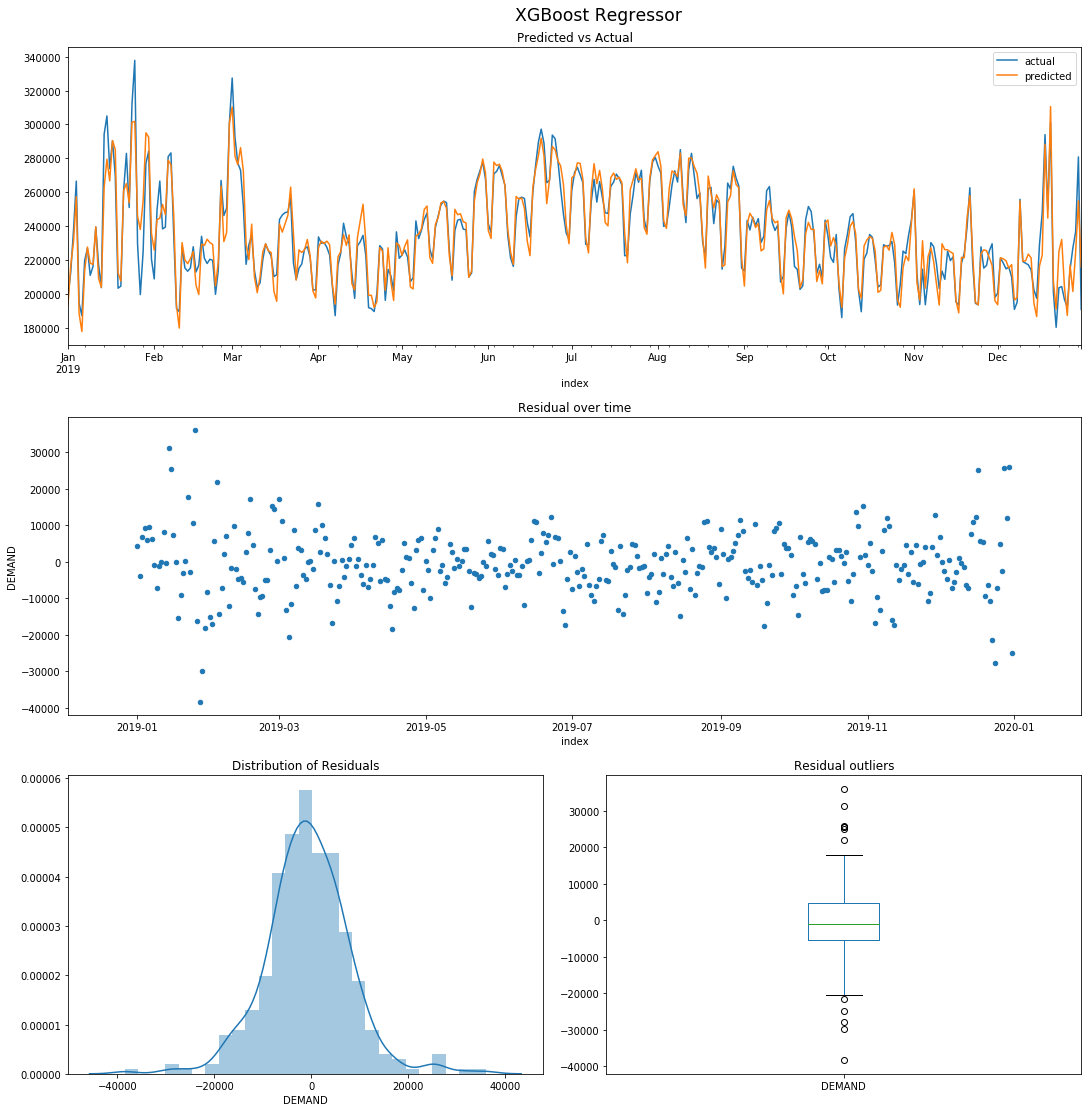

******* RESIDUAL OUTLIERS ********
index
2019-01-27    38410.131250
2019-01-25    36003.815000
2019-01-14    31337.413750
2019-01-28    29907.958750
2019-12-24    27783.280625
2019-12-30    25896.203125
2019-12-28    25589.057500
2019-01-15    25540.208750
2019-12-17    25084.280625
2019-12-31    25020.985625
2019-02-03    21953.013750
2019-12-23    21486.293750
2019-03-05    20587.565000
2019-04-17    18366.240000
2019-01-29    18147.340000
2019-01-22    17765.622500
2019-09-19    17644.614375
2019-11-12    17496.376875
2019-06-28    17485.072500
2019-02-17    17295.756250
2019-03-01    17095.267500
2019-02-01    16969.341875
2019-03-23    16880.012500
2019-11-04    16822.054375
2019-03-17    15698.886875
2019-02-26    15369.214375
2019-10-30    15189.210000
2019-02-27    14406.493125
Name: DEMAND, dtype: float64


In [78]:
mdl = XGBRegressor(
             learning_rate =0.1,
             n_estimators=1000,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=1,
             colsample_bytree=1,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
             reg_alpha=0, reg_lambda=0,
                 seed=27)

# update n_estimators
modelfit(mdl, xgb_train_data, 'DEMAND', xgb_test_data, 
         useTrainCV=True, cv_folds=5, early_stopping_rounds=50)

#### Learning Rate

In [230]:
# update parameters
mdl.set_params(**{'learning_rate':0.1, 'n_estimators':1500})

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=4, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=4, nthread=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=27, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=27, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
600     1822.972925      35.183155    5417.866699      340.8641
******* Numerical Evaluation *********
R2 score: 0.9026382137274777
MAE score: 6496.684683219178
MAPE score 2.7917669560219025
**************************************


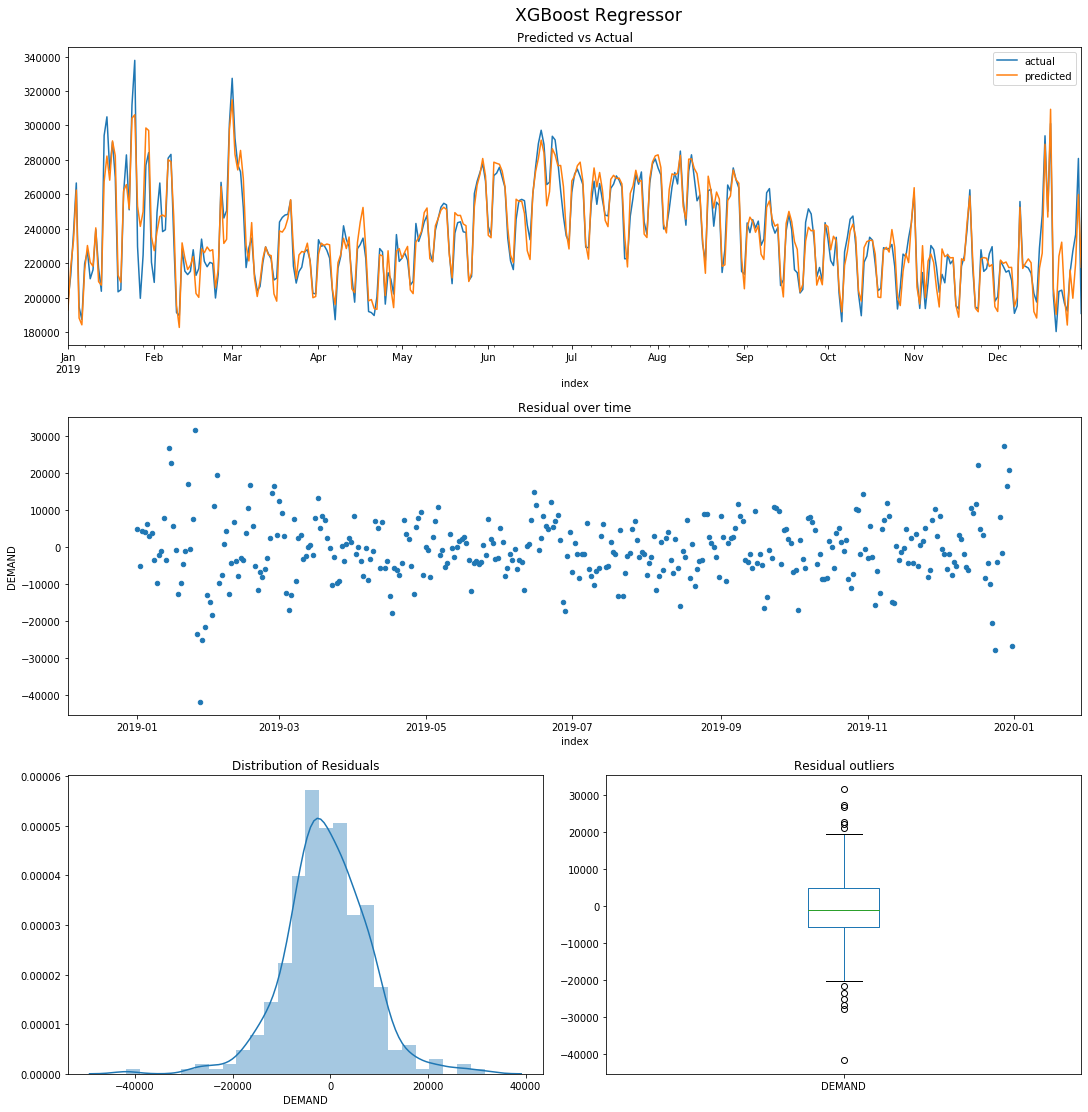

******* RESIDUAL OUTLIERS ********
index
2019-01-27    41775.209375
2019-01-25    31589.877500
2019-12-24    27874.202500
2019-12-28    27388.745000
2019-12-31    26833.751250
2019-01-14    26790.257500
2019-01-28    25142.740000
2019-01-26    23543.013750
2019-01-15    22764.896250
2019-12-17    22163.921250
2019-01-29    21604.933750
2019-12-30    20988.109375
2019-12-23    20436.215625
2019-02-03    19429.279375
2019-02-01    18440.841875
2019-04-17    17813.958750
2019-06-28    17368.947500
2019-01-22    17226.122500
2019-10-03    17018.503125
2019-03-05    17000.221250
2019-02-17    16776.084375
2019-02-27    16681.227500
2019-12-29    16462.909375
2019-06-15    14930.080625
2019-02-26    14743.964375
2019-10-30    14401.350625
Name: DEMAND, dtype: float64


In [80]:
mdl = XGBRegressor(
             learning_rate =0.05,
             n_estimators=1500,
             max_depth=4,
             min_child_weight=4,
             gamma=0,
             subsample=1,
             colsample_bytree=1,
             objective= 'reg:squarederror',
             nthread=4,
             scale_pos_weight=1,
             reg_alpha=0, reg_lambda=0,
                 seed=27)

# update n_estimators
modelfit(mdl, xgb_train_data, 'DEMAND', xgb_test_data, 
         useTrainCV=True, cv_folds=10, early_stopping_rounds=50)

     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
443     1354.507349       24.35098    5416.736572    309.452433
******* Numerical Evaluation *********
R2 score: 0.9948621021288608
MAE score: 1496.1198612270462
MAPE score 0.6240346437453486
**************************************


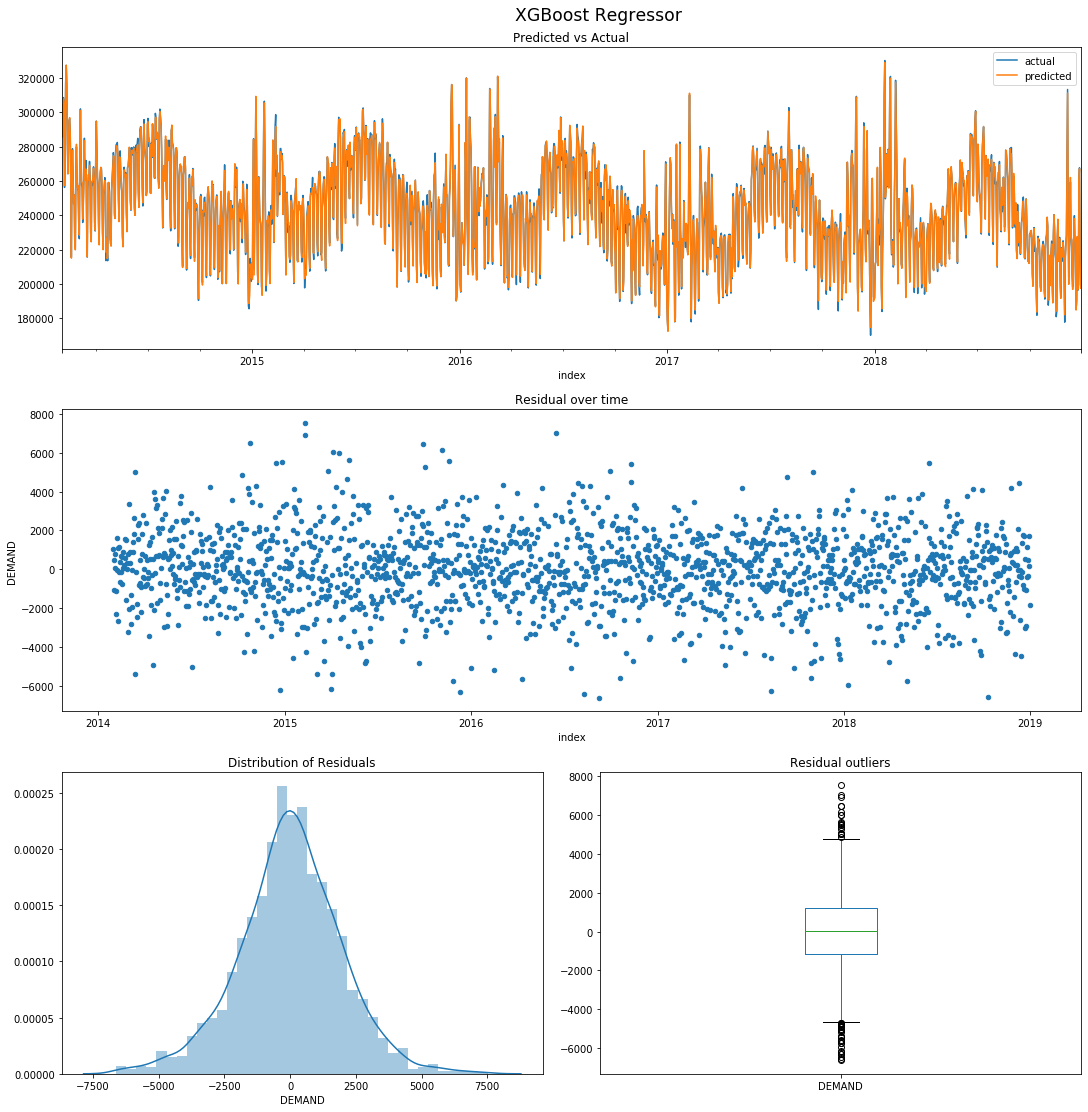

******* RESIDUAL OUTLIERS ********
index
2015-02-10    7539.130000
2016-06-15    7044.305000
2015-02-11    6926.200000
2016-09-08    6619.475000
2018-10-10    6578.808750
                 ...     
2016-09-20    3455.218125
2015-10-03    3437.556250
2014-04-11    3434.770625
2016-09-21    3418.891250
2014-12-06    3417.618750
Name: DEMAND, Length: 141, dtype: float64


In [232]:
# update n_estimators
modelfit(mdl, xgb_train_data, 'DEMAND', xgb_train_data, 
         useTrainCV=True, cv_folds=10, early_stopping_rounds=50)

******* Numerical Evaluation *********
R2 score: 0.9008523237949237
MAE score: 6607.940840355805
MAPE score 2.884284746352426
**************************************


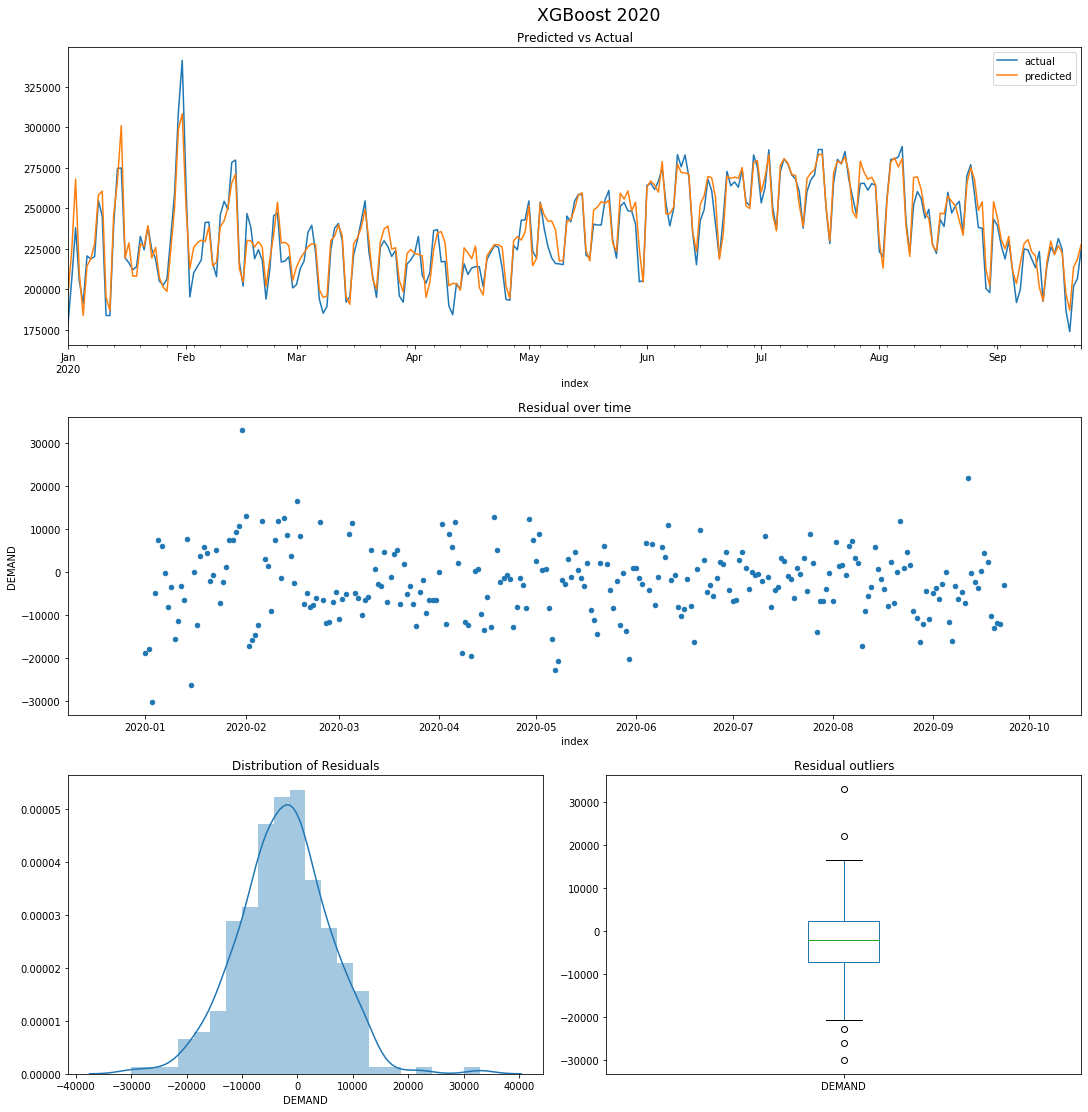

******* RESIDUAL OUTLIERS ********
index
2020-01-31    32964.680000
2020-01-03    30100.101250
2020-01-15    26182.206250
2020-05-07    22781.333750
2020-09-12    21980.387500
2020-02-17    16571.533750
2020-02-01    13071.645625
2020-04-18    12812.777500
2020-02-13    12706.026250
2020-04-29    12279.695625
2020-02-11    11968.675625
2020-08-22    11937.005625
2020-02-06    11832.232500
2020-04-06    11758.583125
2020-02-24    11741.656875
2020-03-05    11421.691875
2020-04-02    11212.939375
2020-06-11    11096.827500
2020-01-30    10728.417500
2020-06-21     9909.953125
2020-01-29     9247.767500
2020-07-25     8931.268125
2020-05-02     8850.465625
2020-03-04     8849.937500
2020-04-04     8799.169375
2020-02-14     8654.416250
2020-02-18     8478.474375
2020-07-11     8358.618750
2020-01-14     7703.835000
2020-01-27     7610.185625
2020-01-28     7591.922500
2020-01-05     7508.462500
2020-04-30     7467.785000
2020-02-10     7395.654375
2020-08-07     7383.313750
Name: DEMAND, 

DEMAND
index                   
2020-01-01 -18736.368125
2020-01-02 -17860.692500
2020-01-03 -30100.101250
2020-01-04  -4817.264375
2020-01-05   7508.462500
...                  ...
2020-09-19 -10242.640625
2020-09-20 -13071.868125
2020-09-21 -11765.303125
2020-09-22 -11923.485625
2020-09-23  -2892.813125

[267 rows x 1 columns]

In [237]:
X_20 = tuning_data['2020'].drop('DEMAND', axis=1)
y_20 = tuning_data['2020']['DEMAND']
evaluate(mdl, "XGBoost 2020", X_20, y_20)

## Code dump

In [65]:
# data preparation
rfr_data_t = VIC_14_20_d[['DEMAND', 'Day','Month','NonWorkingDay',
                         'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                         'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]

# add time satistics
rfr_data_t['DayOfWeek'] = rfr_data_t.index.dayofweek
rfr_data_t[["movave_7", "movstd_7"]] = rfr_data_t['DEMAND'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_7", "maxtempstd_7"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["mintempave_7", "mintempstd_7"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_30", "maxtempstd_30"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
rfr_data_t[["mintempave_30", "mintempstd_30"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
rfr_data_t['Ave_Temp'] = (rfr_data_t['Maximum temperature (Degree C)'] + rfr_data_t['Minimum temperature (Degree C)'])/2
rfr_data_t[["Ave_Temp_ave_7", "Ave_Temp_sd_7"]] = rfr_data_t['Ave_Temp'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["Ave_Temp_ave_30", "Ave_Temp_sd_30"]] = rfr_data_t['Ave_Temp'].rolling(30).agg([np.mean, np.std])
rfr_data_t.dropna(inplace=True)
rfr_data_t.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DEMAND  Day  Month  NonWorkingDay  \
index                                              
2014-01-30  301846.16   30      1            0.0   
2014-01-31  303148.67   31      1            0.0   
2014-02-01  286063.95    1      2            1.0   
2014-02-02  308574.23    2      2            1.0   
2014-02-03  305431.19    3      2            0.0   

            Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
index                                                                        
2014-01-30                            15.0                            28.1   
2014-01-31                            18.4                            24.8   
2014-02-01                            18.1                            27.7   
2014-02-02                            18.1                            38.1   
2014-02-03                            21.8                            34.6   

            Rainfall amount (millimetres)  \
index                                       
2014-01-30                            0.0   
2014-01-31                            0.0   
2014-02-01                            0.0   
2014-02-02                            0.0   
2014-02-03                            0.0   

            Daily global solar exposure (MJ/m*m)  DayOfWeek       movave_7  \
index                                                                        
2014-01-30                                  27.8          3  274473.982857   
2014-01-31                                  27.2          4  279615.737143   
2014-02-01                                  27.6          5  288814.164286   
2014-02-02                                  29.7          6  300400.802857   
2014-02-03                                   7.4          0  305211.655714   

            ...  mintempstd_7  maxtempave_30  maxtempstd_30  mintempave_30  \
index       ...                                                              
2014-01-30  ...      3.430674      27.423333       7.906814      16.470000   
2014-01-31  ...      3.495644      27.366667       7.919741      16.566667   
2014-02-01  ...      3.427549      27.563333       7.849686      16.670000   
2014-02-02  ...      2.428599      28.113333       7.994167      16.830000   
2014-02-03  ...      2.675818      28.573333       7.955780      17.110000   

            mintempstd_30  Ave_Temp  Ave_Temp_ave_7  Ave_Temp_sd_7  \
index                                                                
2014-01-30       4.068224     21.55       22.200000       5.075349   
2014-01-31       4.078821     21.60       22.550000       4.911806   
2014-02-01       4.077030     22.90       23.378571       4.288925   
2014-02-02       4.034177     28.10       24.607143       4.223982   
2014-02-03       4.079161     28.20       24.964286       4.432335   

            Ave_Temp_ave_30  Ave_Temp_sd_30  
index                                        
2014-01-30        21.946667        5.479317  
2014-01-31        21.966667        5.476837  
2014-02-01        22.116667        5.437265  
2014-02-02        22.471667        5.469645  
2014-02-03        22.841667        5.469178  

[5 rows x 24 columns]

R2 score: 0.8719888771060578
MAE score: 7286.3389162740095
MAPE score 3.086839708445432


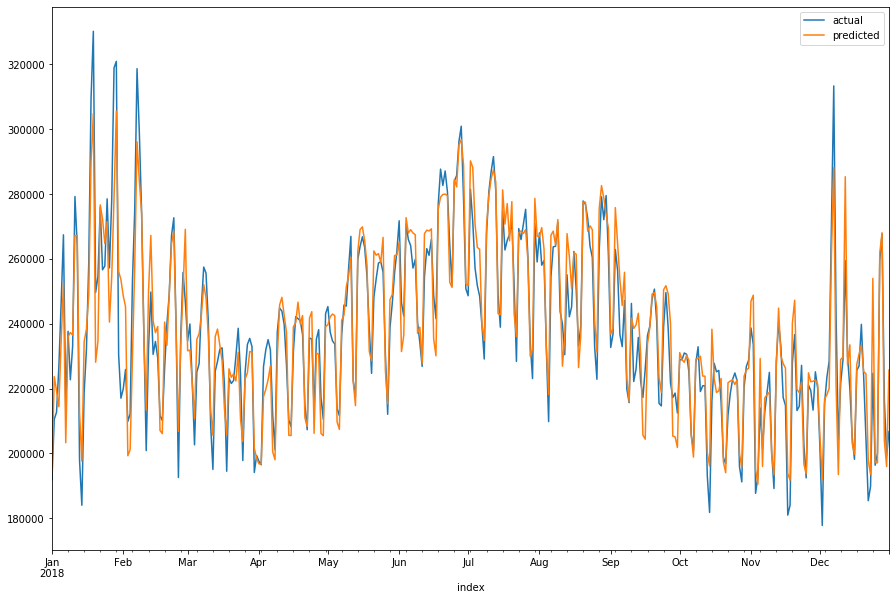

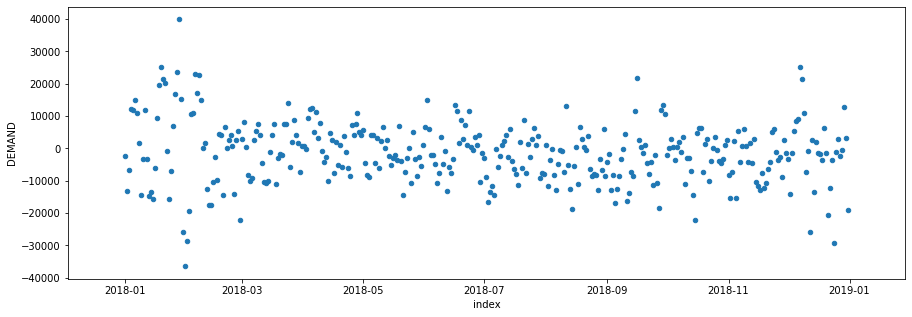

In [66]:
## Model pipeline preparation

## Pipeline preparation
dateCols = ['Month', 'Day','NonWorkingDay','DayOfWeek']
metricCols = ['movave_7', 'movstd_7','Ave_Temp',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Daily global solar exposure (MJ/m*m)',
             'maxtempave_7', 'maxtempstd_7','mintempave_7', 'mintempstd_7']

## Data Transformation
stdScaler = StandardScaler()
#data[metricCols] = stdScaler.fit_transform(data[metricCols])

oheScaler = OneHotEncoder(handle_unknown='ignore')
#oheScaler.fit_transform(data[dateCols])

#rfg = RandomForestRegressor()
preprocessor = ColumnTransformer(
    transformers=[
        ('metrics', stdScaler, metricCols),
        ('dates', oheScaler, dateCols)])

rfr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=1000))])

# train test split
X_train, y_train, X_test, y_test = yearSplit(rfr_data_t, "2014","2017","2018")

# train model
rfr.fit(X_train, y_train)

# evaluate
residuals = evaluate(rfr, X_test, y_test)

#residuals.reset_index().plot.scatter(x="index", y="DEMAND", figsize = (15,5))

In [67]:
rfr_data_t['2019']['DEMAND']

index
2019-01-01    197866.12
2019-01-02    212941.35
2019-01-03    237579.21
2019-01-04    266576.92
2019-01-05    194525.58
                ...    
2019-12-27    214512.13
2019-12-28    227043.37
2019-12-29    236587.05
2019-12-30    280820.25
2019-12-31    190820.78
Freq: D, Name: DEMAND, Length: 365, dtype: float64

R2 score: 0.8775847875082888
MAE score: 7368.669423287709
MAPE score 3.164625150975316


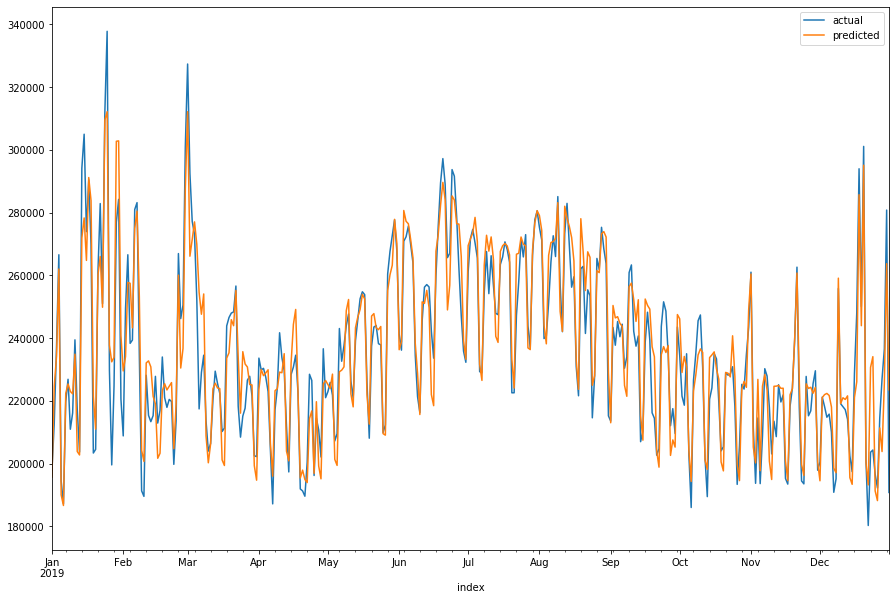

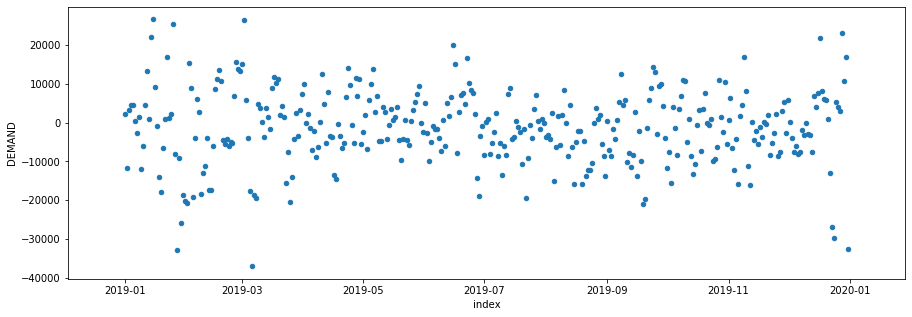

In [68]:
# evaluate
residuals = evaluate(rfr, rfr_data_t['2019'].drop('DEMAND',axis = 1), rfr_data_t['2019']['DEMAND'])

R2 score: 0.8639385076968205
MAE score: 7818.390173633081
MAPE score 3.40764299509026


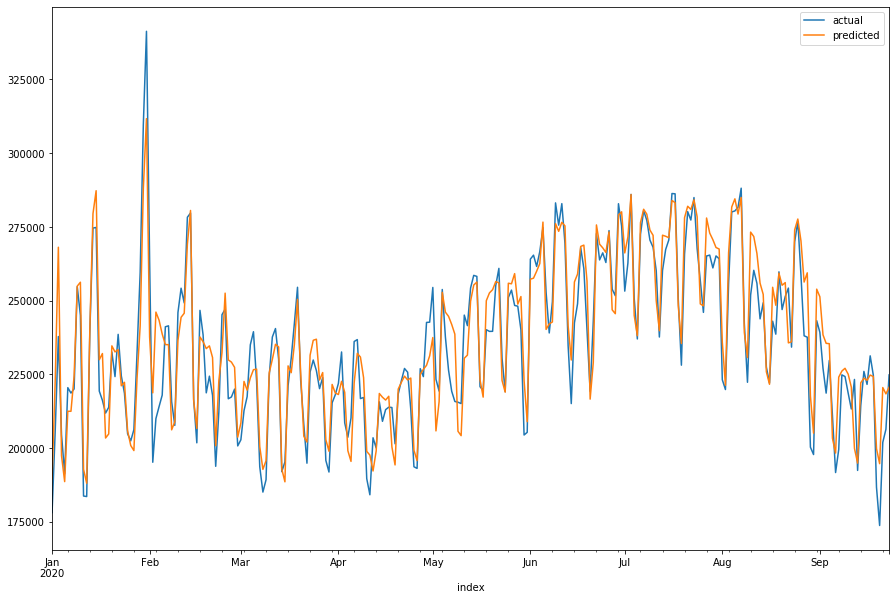

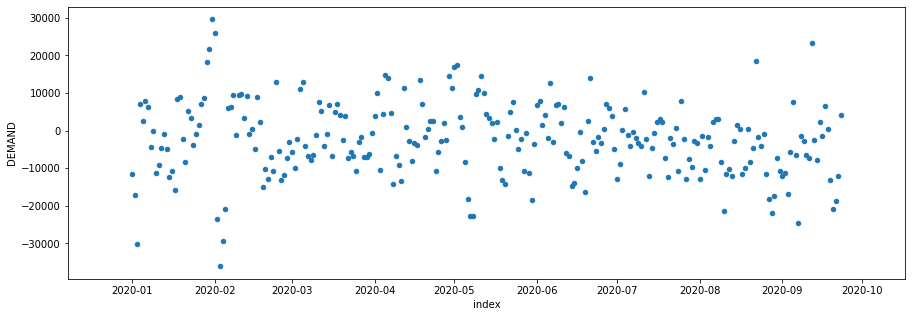

In [69]:
residuals = evaluate(rfr, rfr_data_t['2020'].drop('DEMAND',axis = 1), rfr_data_t['2020']['DEMAND'])

In [63]:
# data preparation
rfr_data_t = VIC_14_20_d[['DEMAND', 'Day','Month','NonWorkingDay',
                         'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
                         'Rainfall amount (millimetres)','Daily global solar exposure (MJ/m*m)']]

# add time satistics
rfr_data_t['DayOfWeek'] = rfr_data_t.index.dayofweek
rfr_data_t[["movave_7", "movstd_7"]] = rfr_data_t['DEMAND'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_7", "maxtempstd_7"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["mintempave_7", "mintempstd_7"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["maxtempave_30", "maxtempstd_30"]] = rfr_data_t['Maximum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
rfr_data_t[["mintempave_30", "mintempstd_30"]] = rfr_data_t['Minimum temperature (Degree C)'].rolling(30).agg([np.mean, np.std])
rfr_data_t['Ave_Temp'] = (rfr_data_t['Maximum temperature (Degree C)'] + rfr_data_t['Minimum temperature (Degree C)'])/2
rfr_data_t[["Ave_Temp_ave_7", "Ave_Temp_sd_7"]] = rfr_data_t['Ave_Temp'].rolling(7).agg([np.mean, np.std])
rfr_data_t[["Ave_Temp_ave_30", "Ave_Temp_sd_30"]] = rfr_data_t['Ave_Temp'].rolling(30).agg([np.mean, np.std])
rfr_data_t.dropna(inplace=True)
rfr_data_t.head()

/home/guinto/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/guinto/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


DEMAND  Day  Month  NonWorkingDay  \
index                                              
2014-01-30  301846.16   30      1            0.0   
2014-01-31  303148.67   31      1            0.0   
2014-02-01  286063.95    1      2            1.0   
2014-02-02  308574.23    2      2            1.0   
2014-02-03  305431.19    3      2            0.0   

            Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
index                                                                        
2014-01-30                            15.0                            28.1   
2014-01-31                            18.4                            24.8   
2014-02-01                            18.1                            27.7   
2014-02-02                            18.1                            38.1   
2014-02-03                            21.8                            34.6   

            Rainfall amount (millimetres)  \
index                                       
2014-01-30                            0.0   
2014-01-31                            0.0   
2014-02-01                            0.0   
2014-02-02                            0.0   
2014-02-03                            0.0   

            Daily global solar exposure (MJ/m*m)  DayOfWeek       movave_7  \
index                                                                        
2014-01-30                                  27.8          3  274473.982857   
2014-01-31                                  27.2          4  279615.737143   
2014-02-01                                  27.6          5  288814.164286   
2014-02-02                                  29.7          6  300400.802857   
2014-02-03                                   7.4          0  305211.655714   

            ...  mintempstd_7  maxtempave_30  maxtempstd_30  mintempave_30  \
index       ...                                                              
2014-01-30  ...      3.430674      27.423333       7.906814      16.470000   
2014-01-31  ...      3.495644      27.366667       7.919741      16.566667   
2014-02-01  ...      3.427549      27.563333       7.849686      16.670000   
2014-02-02  ...      2.428599      28.113333       7.994167      16.830000   
2014-02-03  ...      2.675818      28.573333       7.955780      17.110000   

            mintempstd_30  Ave_Temp  Ave_Temp_ave_7  Ave_Temp_sd_7  \
index                                                                
2014-01-30       4.068224     21.55       22.200000       5.075349   
2014-01-31       4.078821     21.60       22.550000       4.911806   
2014-02-01       4.077030     22.90       23.378571       4.288925   
2014-02-02       4.034177     28.10       24.607143       4.223982   
2014-02-03       4.079161     28.20       24.964286       4.432335   

            Ave_Temp_ave_30  Ave_Temp_sd_30  
index                                        
2014-01-30        21.946667        5.479317  
2014-01-31        21.966667        5.476837  
2014-02-01        22.116667        5.437265  
2014-02-02        22.471667        5.469645  
2014-02-03        22.841667        5.469178  

[5 rows x 24 columns]

******* Numerical Evaluation *********
R2 score: 0.8910390968820978
MAE score: 6955.6801196712295
MAPE score 2.9945456695946695
**************************************


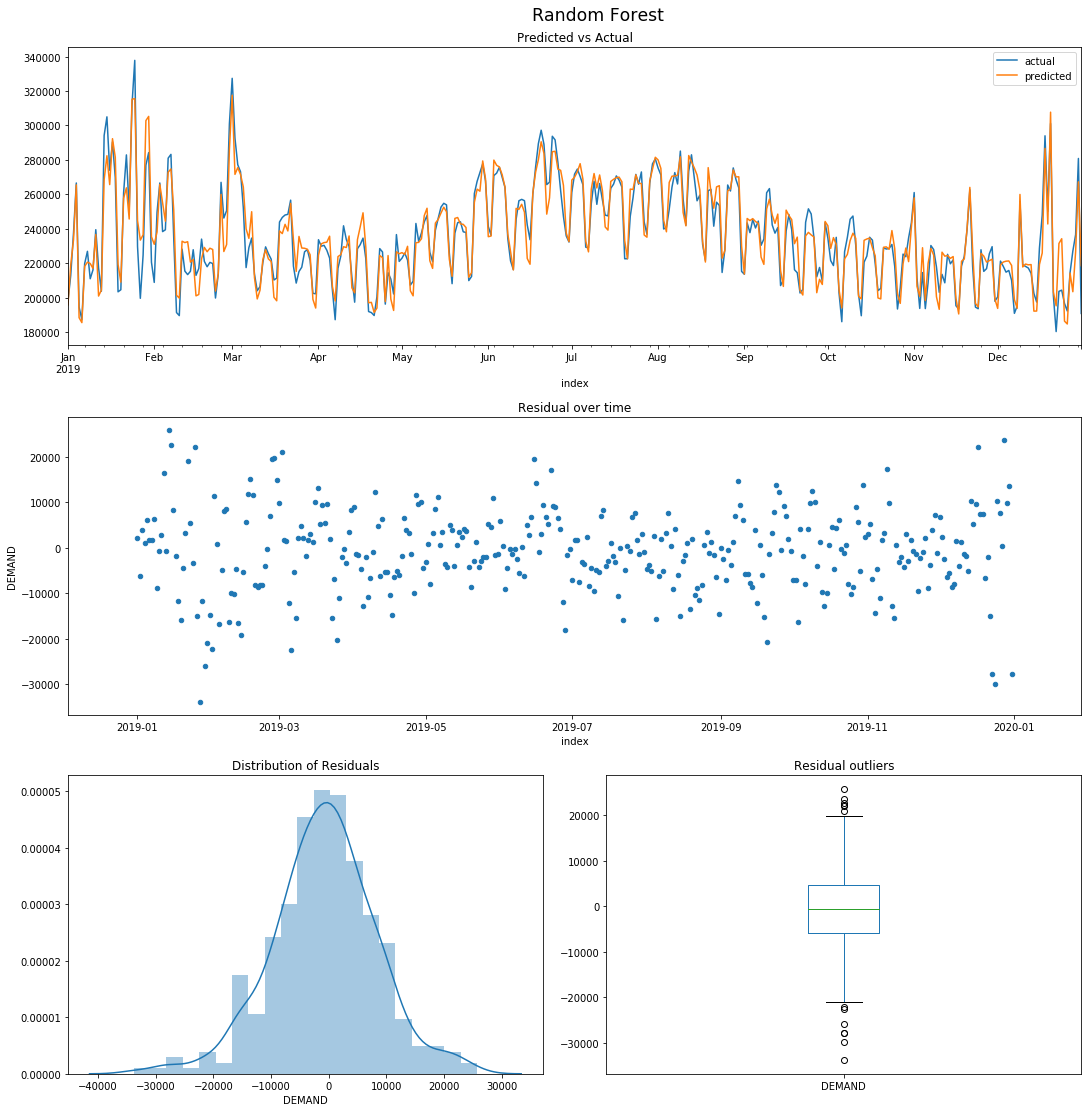

******* RESIDUAL OUTLIERS ********
index
2019-01-27    33802.58160
2019-12-24    29875.03914
2019-12-23    27809.99100
2019-12-31    27759.47494
2019-01-29    25891.24040
2019-01-14    25723.94936
2019-12-28    23609.70800
2019-01-15    22585.22852
2019-03-06    22501.93976
2019-01-25    22207.00724
2019-02-01    22133.56498
2019-12-17    22076.64520
2019-01-30    21023.27964
2019-03-02    20935.45086
2019-09-20    20696.02474
2019-03-25    20368.08522
2019-02-27    19731.11206
2019-06-15    19453.93240
2019-02-26    19446.41606
2019-01-22    19127.01262
2019-02-13    19102.09816
2019-06-28    18126.31822
2019-11-09    17322.67962
2019-06-22    17157.89922
2019-01-12    16335.35750
2019-02-17    15128.42218
2019-02-28    14933.41132
2019-09-08    14677.87948
2019-06-16    14226.44290
Name: DEMAND, dtype: float64


In [104]:
## Model evaluation

# Feature selection
dateCols = ['Month', 'Day','NonWorkingDay','DayOfWeek']
metricCols = ['movave_7', 'movstd_7', #'movave_30', 'movstd_30',
             # 'movave_90', 'movstd_90', 'movave_365', 'movstd_365',
             'Minimum temperature (Degree C)','Maximum temperature (Degree C)', 
             'Daily global solar exposure (MJ/m*m)',
              'maxtempave_7', 'maxtempstd_7','mintempave_7', 'mintempstd_7',
             #'maxtempave_30', 'maxtempstd_30','mintempave_30', 'mintempstd_30',
              'Ave_Temp']#, "Ave_Temp_ave_7", "Ave_Temp_sd_7","Ave_Temp_ave_30", "Ave_Temp_sd_30"]

# Model pipeline initalisation
preprocessor = ColumnTransformer(
    transformers=[
        ('metrics', stdScaler, metricCols),
        ('dates', oheScaler, dateCols)])

rfr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', RandomForestRegressor(n_estimators=500))])

#rfr = RandomForestRegressor(n_estimators=500)

# train test split
X_train, y_train, X_test, y_test = yearSplit(rfr_data_t, "2014","2018","2019")

# train model
rfr.fit(X_train, y_train)

# evaluate
residuals = evaluate(rfr, "Random Forest", X_test, y_test)

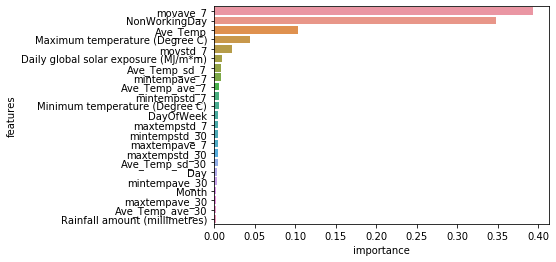

In [72]:
feature_importance = rfr.feature_importances_
df = pd.DataFrame({'features' : X_train.columns,
                    'importance':feature_importance})
ax = sns.barplot(x="importance", y="features", data=df.sort_values(by="importance", ascending=False))

In [105]:
labels = []
for f in metricCols:
    labels.append(f)
    
for f in list(rfr['preprocessor'].transformers_[1][1].get_feature_names(dateCols)):
    labels.append(f)
    
labels

['movave_7',
 'movstd_7',
 'Minimum temperature (Degree C)',
 'Maximum temperature (Degree C)',
 'Daily global solar exposure (MJ/m*m)',
 'maxtempave_7',
 'maxtempstd_7',
 'mintempave_7',
 'mintempstd_7',
 'Ave_Temp',
 'Month_1',
 'Month_2',
 'Month_3',
 'Month_4',
 'Month_5',
 'Month_6',
 'Month_7',
 'Month_8',
 'Month_9',
 'Month_10',
 'Month_11',
 'Month_12',
 'Day_1',
 'Day_2',
 'Day_3',
 'Day_4',
 'Day_5',
 'Day_6',
 'Day_7',
 'Day_8',
 'Day_9',
 'Day_10',
 'Day_11',
 'Day_12',
 'Day_13',
 'Day_14',
 'Day_15',
 'Day_16',
 'Day_17',
 'Day_18',
 'Day_19',
 'Day_20',
 'Day_21',
 'Day_22',
 'Day_23',
 'Day_24',
 'Day_25',
 'Day_26',
 'Day_27',
 'Day_28',
 'Day_29',
 'Day_30',
 'Day_31',
 'NonWorkingDay_0.0',
 'NonWorkingDay_1.0',
 'DayOfWeek_0',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6']

In [108]:
rfr['regressor'].feature_importances_

array([3.95215794e-01, 2.71848735e-02, 7.01653349e-03, 4.53253115e-02,
       1.12651127e-02, 8.47230139e-03, 7.87876380e-03, 1.58021464e-02,
       9.56107906e-03, 1.05889113e-01, 6.94456724e-04, 3.77238908e-04,
       3.22693849e-04, 6.55066231e-04, 1.33613847e-04, 2.61666318e-04,
       1.41451486e-04, 2.80613862e-04, 4.85645627e-04, 3.52207566e-04,
       2.84083038e-04, 1.05239129e-03, 2.44731294e-04, 3.56540379e-04,
       3.15267470e-04, 2.43996937e-04, 2.89665981e-04, 3.24683011e-04,
       3.27034850e-04, 1.50308152e-04, 1.91497824e-04, 2.04056481e-04,
       4.40723289e-04, 3.08923742e-04, 2.95387081e-04, 3.34864129e-04,
       2.15921212e-04, 1.38338475e-04, 1.89167558e-04, 1.23399167e-04,
       1.95007973e-04, 1.77147133e-04, 2.29517853e-04, 2.27333942e-04,
       1.36159528e-04, 3.54381665e-04, 1.66362493e-04, 1.18072744e-04,
       1.90754761e-04, 2.26038592e-04, 1.55567931e-04, 1.83145970e-04,
       1.35819839e-04, 1.73765364e-01, 1.74234014e-01, 1.06574902e-03,
      

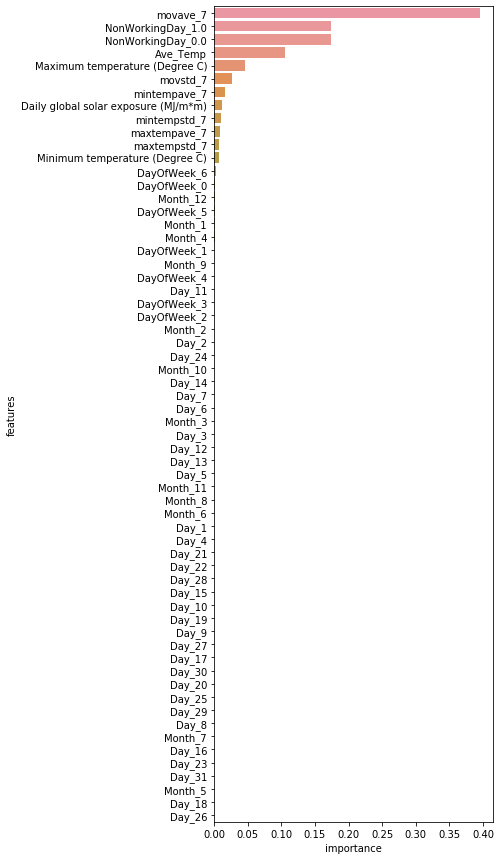

In [113]:
feature_importance = rfr['regressor'].feature_importances_
df = pd.DataFrame({'features' : labels,
                   'importance':feature_importance})
fig, ax = plt.subplots(figsize=(5,15))
sns.barplot(x="importance", y="features", data=df.sort_values(by="importance", ascending=False), ax = ax)
plt.show()